# 1. 导入数据和包

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import lightgbm

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
import statsmodels.api as sm

In [3]:
#设置
pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000)

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
df_raw=pd.read_csv('train.csv', low_memory=False, parse_dates=['date'], index_col=['date'])

# 2.检查数据

## 简单的数据检查

In [5]:
df_raw.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [6]:
df_raw.isnull().sum()

store    0
item     0
sales    0
dtype: int64

In [7]:
df_raw['item'].value_counts()

50    18260
13    18260
23    18260
22    18260
21    18260
20    18260
19    18260
18    18260
17    18260
16    18260
15    18260
14    18260
12    18260
49    18260
11    18260
10    18260
9     18260
8     18260
7     18260
6     18260
5     18260
4     18260
3     18260
2     18260
24    18260
25    18260
26    18260
27    18260
48    18260
47    18260
46    18260
45    18260
44    18260
43    18260
42    18260
41    18260
40    18260
39    18260
38    18260
37    18260
36    18260
35    18260
34    18260
33    18260
32    18260
31    18260
30    18260
29    18260
28    18260
1     18260
Name: item, dtype: int64

In [8]:
df_raw['store'].value_counts()  # 10个店铺

10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store, dtype: int64

In [9]:
df_raw['item'].unique()  # 50个物品

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [10]:
df_raw.shape

(913000, 3)

In [11]:
df_raw.index.unique()  # 5年时间

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq=None)

## 检查时间序列的季节性

In [12]:
# 准备工作：输入值必须是float type（小数形式）
df_raw['sales'] = df_raw['sales'] * 1.0

In [13]:
# 选取几个示例店铺的销售数据进行预测（你可以使用for循环，把所有店铺都添加进来）
sales_a=df_raw[df_raw.store==1]['sales'].sort_index(ascending=True) # 解决倒序
sales_b=df_raw[df_raw.store==2]['sales'].sort_index(ascending=True)
sales_c=df_raw[df_raw.store==3]['sales'].sort_index(ascending=True)
sales_d=df_raw[df_raw.store==4]['sales'].sort_index(ascending=True)

<AxesSubplot:xlabel='date'>

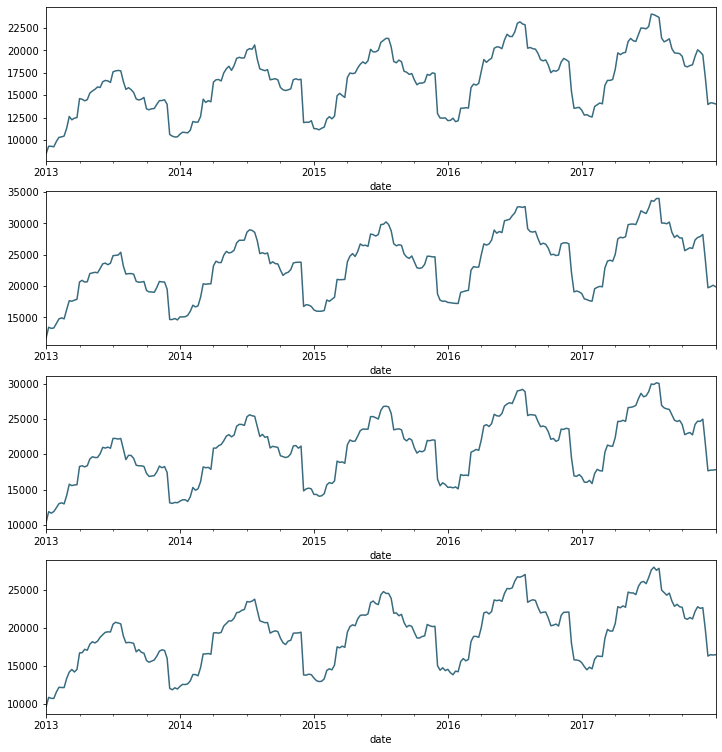

In [14]:
#对上面的数据绘制图形
f, (ax1, ax2, ax3, ax4)=plt.subplots(4, figsize=(12, 13))
c='#386B7F'
#按周"W"resample数据，对加总值绘制折线图
sales_a.resample('W').sum().plot(color=c, ax=ax1)
sales_b.resample('W').sum().plot(color=c, ax=ax2)
sales_c.resample('W').sum().plot(color=c, ax=ax3)
sales_d.resample('W').sum().plot(color=c, ax=ax4)

<AxesSubplot:xlabel='date'>

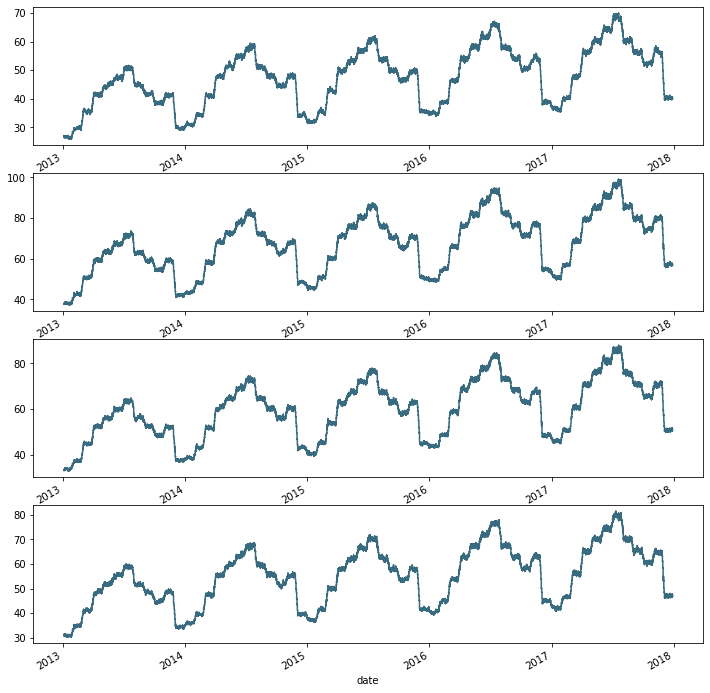

In [16]:
#按年加总绘制，所有店铺的可视化图形都是一样的
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

decomposition_a=sm.tsa.seasonal_decompose(sales_a, model='additive', period=365)
decomposition_a.trend.plot(color = c, ax = ax1)
decomposition_b=sm.tsa.seasonal_decompose(sales_b, model='additive', period=365)
decomposition_b.trend.plot(color = c, ax = ax2)
decomposition_c=sm.tsa.seasonal_decompose(sales_c, model='additive', period=365)
decomposition_c.trend.plot(color = c, ax = ax3)
decomposition_d=sm.tsa.seasonal_decompose(sales_d, model='additive', period=365)
decomposition_d.trend.plot(color = c, ax = ax4)

#可以从中发现非常明显的季节性

In [17]:
date_sales=df_raw.drop(['store', 'item'], axis=1).copy()

In [18]:
y=date_sales['sales'].resample('MS').sum()

<AxesSubplot:xlabel='date'>

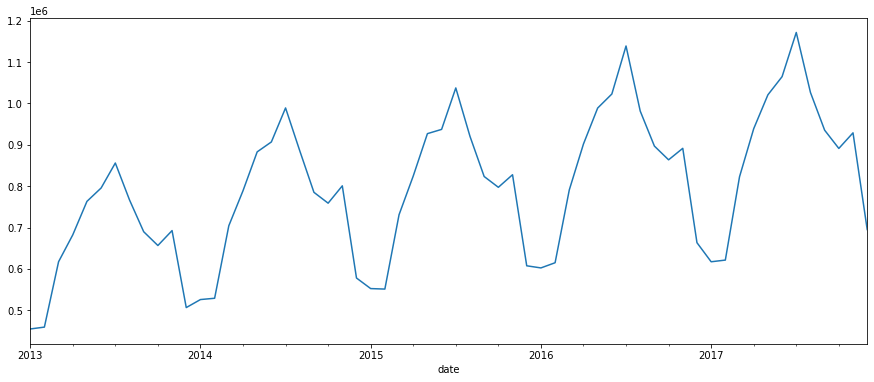

In [19]:
y.plot(figsize=(15, 6))#绘制月均销售数据图
#可以发现季节性波动，在每年的年末销售量最低，在年中销售量最高

In [20]:
#为了进一步探究数据情况，我们可以对数据进行一个时间序列的分解
#分解为趋势、季节性和误差，这里使用statsmodels可以非常方便的完成这一点
#加法模型
decomposition=sm.tsa.seasonal_decompose(y, model='additive')
decomposition

In [21]:
decomposition?

Type:        DecomposeResult
String form: <statsmodels.tsa.seasonal.DecomposeResult object at 0x000002115FB21088>
File:        d:\programing\anaconda3\lib\site-packages\statsmodels\tsa\seasonal.py
Docstring:  
Results class for seasonal decompositions

Parameters
----------
observed : array_like
    The data series that has been decomposed.
seasonal : array_like
    The seasonal component of the data series.
trend : array_like
    The trend component of the data series.
resid : array_like
    The residual component of the data series.
weights : array_like, optional
    The weights used to reduce outlier influence.


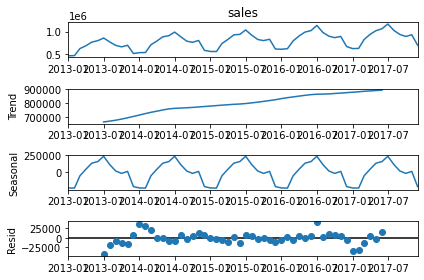

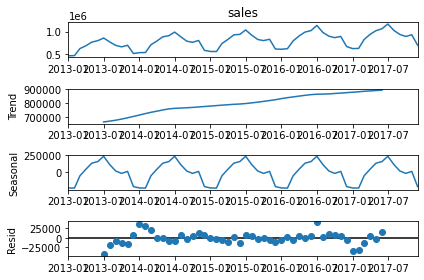

In [22]:
decomposition.plot()

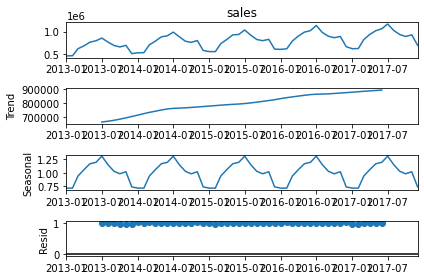

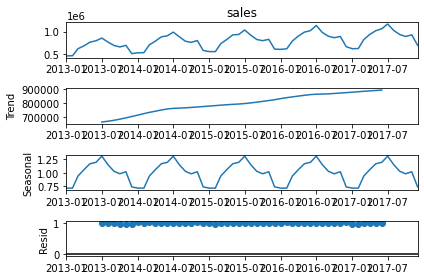

In [23]:
#乘法模型
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot()

# 3. 建立ARIMA/自回归移动平均模型模型

In [44]:
#使用常见的时间序列模型ARIMA(p,d,q)来进行预测
#ARIMA是指将非平稳时间序列转化为平稳时间序列
#然后将因变量仅对它的滞后值以及随机误差项的现值和滞后值进行回归所建立的模型

#其中p,d,q分别代表了数据中的季节性，趋势和噪音

##AR代指Auto-Regressive (p): 
#这里的p是指lags滞后的阶数，例如p=3, 那么我们会用x(t-1), x(t-2) 和x(t-3) 来预测 x(t)

##I代指Integrated (d): 
#代表非季节性的差异，例如在这个案例中，我们使用了一阶差分，所以我们让d=0

##MA代指Moving Averages (q): 代表预测中滞后的预测误差

In [24]:
import itertools
p=d=q=range(0,3)
pdq=list(itertools.product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


In [25]:
seasonal_pdq=[(x[0], x[1], x[2], 12) for x in pdq]
print(seasonal_pdq)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


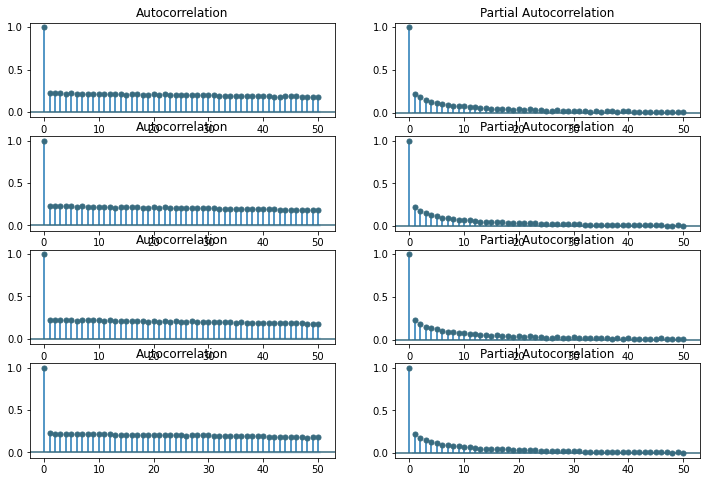

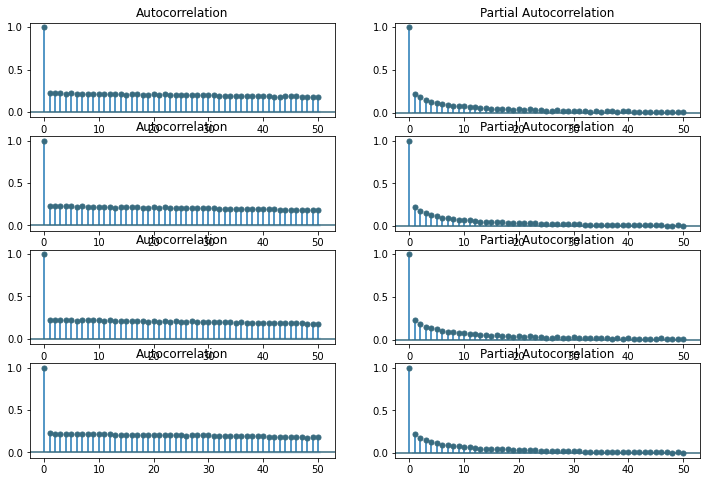

In [26]:
# 导入acf和pacf图的绘制工具，绘制多组子图subplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize = (12, 8))

plt.subplot(421); plot_acf(sales_a, lags=50, ax=plt.gca(), color=c)
plt.subplot(422); plot_pacf(sales_a, lags=50, ax=plt.gca(), color=c)

plt.subplot(423); plot_acf(sales_b, lags=50, ax=plt.gca(), color=c)
plt.subplot(424); plot_pacf(sales_b, lags=50, ax=plt.gca(), color=c)

plt.subplot(425); plot_acf(sales_c, lags=50, ax=plt.gca(), color=c)
plt.subplot(426); plot_pacf(sales_c, lags=50, ax=plt.gca(), color=c)

plt.subplot(427); plot_acf(sales_d, lags=50, ax=plt.gca(), color=c)
plt.subplot(428); plot_pacf(sales_d, lags=50, ax=plt.gca(), color=c)

In [51]:
#这些图形展示了时间序列是有自相关性的

In [55]:
#由于有些组合不能收敛，所以我们使用try-except来寻找最佳的参数组合
#需要数分钟的时间运行
cnt = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            cnt += 1
            if cnt % 50 :
                print('Current Iter - {}, ARIMA{}x{} 12 - AIC:{}'.format(cnt, param, param_seasonal, results.aic))
        except:
            continue

Current Iter - 1, ARIMA(0, 0, 0)x(0, 0, 0, 12) 12 - AIC:1775.9743967500065
Current Iter - 2, ARIMA(0, 0, 0)x(0, 0, 1, 12) 12 - AIC:1386.8929242855202
Current Iter - 3, ARIMA(0, 0, 0)x(0, 0, 2, 12) 12 - AIC:1059.9186292427057
Current Iter - 4, ARIMA(0, 0, 0)x(0, 1, 0, 12) 12 - AIC:1179.6266962860743

D:\Programing\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 5, ARIMA(0, 0, 0)x(0, 1, 1, 12) 12 - AIC:1382.4750307102913
Current Iter - 6, ARIMA(0, 0, 0)x(0, 1, 2, 12) 12 - AIC:526.6985631155779
Current Iter - 7, ARIMA(0, 0, 0)x(0, 2, 0, 12) 12 - AIC:862.979363415314
Current Iter - 8, ARIMA(0, 0, 0)x(0, 2, 1, 12) 12 - AIC:547.8383432399221
Current Iter - 9, ARIMA(0, 0, 0)x(0, 2, 2, 12) 12 - AIC:261.83581412311787
Current Iter - 10, ARIMA(0, 0, 0)x(1, 0, 0, 12) 12 - AIC:1141.2214771727804
Current Iter - 11, ARIMA(0, 0, 0)x(1, 0, 1, 12) 12 - AIC:1064.2900067414414
Current Iter - 12, ARIMA(0, 0, 0)x(1, 0, 2, 12) 12 - AIC:914.9282381841018
Current Iter - 13, ARIMA(0, 0, 0)x(1, 1, 0, 12) 12 - AIC:854.7922751569532


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 14, ARIMA(0, 0, 0)x(1, 1, 1, 12) 12 - AIC:1362.4529746790308
Current Iter - 15, ARIMA(0, 0, 0)x(1, 1, 2, 12) 12 - AIC:527.2986930547432
Current Iter - 16, ARIMA(0, 0, 0)x(1, 2, 0, 12) 12 - AIC:536.7473637529097

D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Current Iter - 17, ARIMA(0, 0, 0)x(1, 2, 1, 12) 12 - AIC:541.5901968550681
Current Iter - 18, ARIMA(0, 0, 0)x(1, 2, 2, 12) 12 - AIC:263.6887332990631
Current Iter - 19, ARIMA(0, 0, 0)x(2, 0, 0, 12) 12 - AIC:799.4569382542611
Current Iter - 20, ARIMA(0, 0, 0)x(2, 0, 1, 12) 12 - AIC:775.0983971082994
Current Iter - 21, ARIMA(0, 0, 0)x(2, 0, 2, 12) 12 - AIC:917.2245797413168
Current Iter - 22, ARIMA(0, 0, 0)x(2, 1, 0, 12) 12 - AIC:517.9111218306846
Current Iter - 23, ARIMA(0, 0, 0)x(2, 1, 1, 12) 12 - AIC:513.1052170268688


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 24, ARIMA(0, 0, 0)x(2, 1, 2, 12) 12 - AIC:529.3048163164141
Current Iter - 25, ARIMA(0, 0, 0)x(2, 2, 0, 12) 12 - AIC:261.49594832529567
Current Iter - 26, ARIMA(0, 0, 0)x(2, 2, 1, 12) 12 - AIC:287.25928792479715


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 27, ARIMA(0, 0, 0)x(2, 2, 2, 12) 12 - AIC:265.646914234154
Current Iter - 28, ARIMA(0, 0, 1)x(0, 0, 0, 12) 12 - AIC:1708.325991194349
Current Iter - 29, ARIMA(0, 0, 1)x(0, 0, 1, 12) 12 - AIC:1348.6057141734514
Current Iter - 30, ARIMA(0, 0, 1)x(0, 0, 2, 12) 12 - AIC:1029.4958895796783
Current Iter - 31, ARIMA(0, 0, 1)x(0, 1, 0, 12) 12 - AIC:1122.843561434729
Current Iter - 32, ARIMA(0, 0, 1)x(0, 1, 1, 12) 12 - AIC:3031.6001680738964
Current Iter - 33, ARIMA(0, 0, 1)x(0, 1, 2, 12) 12 - AIC:535.6627758341516
Current Iter - 34, ARIMA(0, 0, 1)x(0, 2, 0, 12) 12 - AIC:813.4321273836284
Current Iter - 35, ARIMA(0, 0, 1)x(0, 2, 1, 12) 12 - AIC:522.2408095116418
Current Iter - 36, ARIMA(0, 0, 1)x(0, 2, 2, 12) 12 - AIC:240.62137153456746
Current Iter - 37, ARIMA(0, 0, 1)x(1, 0, 0, 12) 12 - AIC:1401.0471793597308
Current Iter - 38, ARIMA(0, 0, 1)x(1, 0, 1, 12) 12 - AIC:1436.3287126587043
Current Iter - 39, ARIMA(0, 0, 1)x(1, 0, 2, 12) 12 - AIC:1030.985591861218
Current Iter - 40, A

D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 42, ARIMA(0, 0, 1)x(1, 1, 2, 12) 12 - AIC:536.4503056724877
Current Iter - 43, ARIMA(0, 0, 1)x(1, 2, 0, 12) 12 - AIC:566.6410040174017
Current Iter - 44, ARIMA(0, 0, 1)x(1, 2, 1, 12) 12 - AIC:520.2134735681168


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 45, ARIMA(0, 0, 1)x(1, 2, 2, 12) 12 - AIC:242.58757637500503
Current Iter - 46, ARIMA(0, 0, 1)x(2, 0, 0, 12) 12 - AIC:1091.3343887324047
Current Iter - 47, ARIMA(0, 0, 1)x(2, 0, 1, 12) 12 - AIC:1091.745706849829
Current Iter - 48, ARIMA(0, 0, 1)x(2, 0, 2, 12) 12 - AIC:1032.9739013215144
Current Iter - 49, ARIMA(0, 0, 1)x(2, 1, 0, 12) 12 - AIC:582.7405245917386


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 51, ARIMA(0, 0, 1)x(2, 1, 2, 12) 12 - AIC:538.5502827970901
Current Iter - 52, ARIMA(0, 0, 1)x(2, 2, 0, 12) 12 - AIC:287.10908340938266


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 53, ARIMA(0, 0, 1)x(2, 2, 1, 12) 12 - AIC:289.11464923388866


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 54, ARIMA(0, 0, 1)x(2, 2, 2, 12) 12 - AIC:244.56798890155284
Current Iter - 55, ARIMA(0, 0, 2)x(0, 0, 0, 12) 12 - AIC:1669.4370750586736
Current Iter - 56, ARIMA(0, 0, 2)x(0, 0, 1, 12) 12 - AIC:1316.3524558642052
Current Iter - 57, ARIMA(0, 0, 2)x(0, 0, 2, 12) 12 - AIC:1032.037551997873
Current Iter - 58, ARIMA(0, 0, 2)x(0, 1, 0, 12) 12 - AIC:1085.1248127942522


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 59, ARIMA(0, 0, 2)x(0, 1, 1, 12) 12 - AIC:1241.3354637438933
Current Iter - 60, ARIMA(0, 0, 2)x(0, 1, 2, 12) 12 - AIC:507.78514346230236
Current Iter - 61, ARIMA(0, 0, 2)x(0, 2, 0, 12) 12 - AIC:781.7979090140077
Current Iter - 62, ARIMA(0, 0, 2)x(0, 2, 1, 12) 12 - AIC:495.9120074589549


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 63, ARIMA(0, 0, 2)x(0, 2, 2, 12) 12 - AIC:216.32258718232288
Current Iter - 64, ARIMA(0, 0, 2)x(1, 0, 0, 12) 12 - AIC:1401.774392868031
Current Iter - 65, ARIMA(0, 0, 2)x(1, 0, 1, 12) 12 - AIC:1316.604124909161
Current Iter - 66, ARIMA(0, 0, 2)x(1, 0, 2, 12) 12 - AIC:1034.0158265740674
Current Iter - 67, ARIMA(0, 0, 2)x(1, 1, 0, 12) 12 - AIC:865.1055762877586


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 68, ARIMA(0, 0, 2)x(1, 1, 1, 12) 12 - AIC:1240.6092789811744
Current Iter - 69, ARIMA(0, 0, 2)x(1, 1, 2, 12) 12 - AIC:509.2508423935235
Current Iter - 70, ARIMA(0, 0, 2)x(1, 2, 0, 12) 12 - AIC:561.4975354511951
Current Iter - 71, ARIMA(0, 0, 2)x(1, 2, 1, 12) 12 - AIC:493.5140689315192


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 72, ARIMA(0, 0, 2)x(1, 2, 2, 12) 12 - AIC:218.29960212989445


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 73, ARIMA(0, 0, 2)x(2, 0, 0, 12) 12 - AIC:1067.7190642573632


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 74, ARIMA(0, 0, 2)x(2, 0, 1, 12) 12 - AIC:1077.8506299586277
Current Iter - 75, ARIMA(0, 0, 2)x(2, 0, 2, 12) 12 - AIC:1036.01584779738
Current Iter - 76, ARIMA(0, 0, 2)x(2, 1, 0, 12) 12 - AIC:578.3807903892571
Current Iter - 77, ARIMA(0, 0, 2)x(2, 1, 1, 12) 12 - AIC:579.8675729948864
Current Iter - 78, ARIMA(0, 0, 2)x(2, 1, 2, 12) 12 - AIC:511.2518608399658
Current Iter - 79, ARIMA(0, 0, 2)x(2, 2, 0, 12) 12 - AIC:285.22485893757903


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 80, ARIMA(0, 0, 2)x(2, 2, 1, 12) 12 - AIC:287.1915956299376


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 81, ARIMA(0, 0, 2)x(2, 2, 2, 12) 12 - AIC:220.26311879702538
Current Iter - 82, ARIMA(0, 1, 0)x(0, 0, 0, 12) 12 - AIC:1510.3936908291362
Current Iter - 83, ARIMA(0, 1, 0)x(0, 0, 1, 12) 12 - AIC:1176.2427303697061
Current Iter - 84, ARIMA(0, 1, 0)x(0, 0, 2, 12) 12 - AIC:861.3657591410931
Current Iter - 85, ARIMA(0, 1, 0)x(0, 1, 0, 12) 12 - AIC:1029.82305344997


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 86, ARIMA(0, 1, 0)x(0, 1, 1, 12) 12 - AIC:1377.8241462580113
Current Iter - 87, ARIMA(0, 1, 0)x(0, 1, 2, 12) 12 - AIC:491.4961671240561
Current Iter - 88, ARIMA(0, 1, 0)x(0, 2, 0, 12) 12 - AIC:786.3398407283399
Current Iter - 89, ARIMA(0, 1, 0)x(0, 2, 1, 12) 12 - AIC:502.6502370022773
Current Iter - 90, ARIMA(0, 1, 0)x(0, 2, 2, 12) 12 - AIC:227.39968298616986
Current Iter - 91, ARIMA(0, 1, 0)x(1, 0, 0, 12) 12 - AIC:1046.9035784828386
Current Iter - 92, ARIMA(0, 1, 0)x(1, 0, 1, 12) 12 - AIC:1015.1085360834184
Current Iter - 93, ARIMA(0, 1, 0)x(1, 0, 2, 12) 12 - AIC:857.0491494880054
Current Iter - 94, ARIMA(0, 1, 0)x(1, 1, 0, 12) 12 - AIC:776.6169638221934


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 95, ARIMA(0, 1, 0)x(1, 1, 1, 12) 12 - AIC:1418.9715198918661
Current Iter - 96, ARIMA(0, 1, 0)x(1, 1, 2, 12) 12 - AIC:492.46789634958327
Current Iter - 97, ARIMA(0, 1, 0)x(1, 2, 0, 12) 12 - AIC:521.4405050388655
Current Iter - 98, ARIMA(0, 1, 0)x(1, 2, 1, 12) 12 - AIC:503.2918792893131
Current Iter - 99, ARIMA(0, 1, 0)x(1, 2, 2, 12) 12 - AIC:229.62730344429667
Current Iter - 101, ARIMA(0, 1, 0)x(2, 0, 1, 12) 12 - AIC:776.3384002348954
Current Iter - 102, ARIMA(0, 1, 0)x(2, 0, 2, 12) 12 - AIC:858.9860415240382
Current Iter - 103, ARIMA(0, 1, 0)x(2, 1, 0, 12) 12 - AIC:515.8873162273709


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 104, ARIMA(0, 1, 0)x(2, 1, 1, 12) 12 - AIC:883.0753641656823
Current Iter - 105, ARIMA(0, 1, 0)x(2, 1, 2, 12) 12 - AIC:493.05379622804384
Current Iter - 106, ARIMA(0, 1, 0)x(2, 2, 0, 12) 12 - AIC:250.68739331137513
Current Iter - 107, ARIMA(0, 1, 0)x(2, 2, 1, 12) 12 - AIC:251.17040002401407
Current Iter - 108, ARIMA(0, 1, 0)x(2, 2, 2, 12) 12 - AIC:230.59746035894594
Current Iter - 109, ARIMA(0, 1, 1)x(0, 0, 0, 12) 12 - AIC:1483.1490870580737
Current Iter - 110, ARIMA(0, 1, 1)x(0, 0, 1, 12) 12 - AIC:1195.2054636584899
Current Iter - 111, ARIMA(0, 1, 1)x(0, 0, 2, 12) 12 - AIC:837.5967810915707
Current Iter - 112, ARIMA(0, 1, 1)x(0, 1, 0, 12) 12 - AIC:1009.3959760989883


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 113, ARIMA(0, 1, 1)x(0, 1, 1, 12) 12 - AIC:1276.2814465928595
Current Iter - 114, ARIMA(0, 1, 1)x(0, 1, 2, 12) 12 - AIC:464.2181215043888
Current Iter - 115, ARIMA(0, 1, 1)x(0, 2, 0, 12) 12 - AIC:765.1091002210494
Current Iter - 116, ARIMA(0, 1, 1)x(0, 2, 1, 12) 12 - AIC:478.25120637799836
Current Iter - 117, ARIMA(0, 1, 1)x(0, 2, 2, 12) 12 - AIC:209.11305387418975
Current Iter - 118, ARIMA(0, 1, 1)x(1, 0, 0, 12) 12 - AIC:1180.4604577690761
Current Iter - 119, ARIMA(0, 1, 1)x(1, 0, 1, 12) 12 - AIC:1132.1774807627796
Current Iter - 120, ARIMA(0, 1, 1)x(1, 0, 2, 12) 12 - AIC:834.2079171670894
Current Iter - 121, ARIMA(0, 1, 1)x(1, 1, 0, 12) 12 - AIC:779.042837531853


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 122, ARIMA(0, 1, 1)x(1, 1, 1, 12) 12 - AIC:1290.3453558250344


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 123, ARIMA(0, 1, 1)x(1, 1, 2, 12) 12 - AIC:464.18089970842595
Current Iter - 124, ARIMA(0, 1, 1)x(1, 2, 0, 12) 12 - AIC:527.0655052180605
Current Iter - 125, ARIMA(0, 1, 1)x(1, 2, 1, 12) 12 - AIC:479.2381622883183
Current Iter - 126, ARIMA(0, 1, 1)x(1, 2, 2, 12) 12 - AIC:210.70079717829498
Current Iter - 127, ARIMA(0, 1, 1)x(2, 0, 0, 12) 12 - AIC:882.3905740340629
Current Iter - 128, ARIMA(0, 1, 1)x(2, 0, 1, 12) 12 - AIC:884.3876213989672
Current Iter - 129, ARIMA(0, 1, 1)x(2, 0, 2, 12) 12 - AIC:836.1855769291319
Current Iter - 130, ARIMA(0, 1, 1)x(2, 1, 0, 12) 12 - AIC:517.7497287738919


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 131, ARIMA(0, 1, 1)x(2, 1, 1, 12) 12 - AIC:961.2294546449534
Current Iter - 132, ARIMA(0, 1, 1)x(2, 1, 2, 12) 12 - AIC:465.41136917329874
Current Iter - 133, ARIMA(0, 1, 1)x(2, 2, 0, 12) 12 - AIC:253.5804408707856
Current Iter - 134, ARIMA(0, 1, 1)x(2, 2, 1, 12) 12 - AIC:255.1412548829981


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 135, ARIMA(0, 1, 1)x(2, 2, 2, 12) 12 - AIC:212.57413428795869
Current Iter - 136, ARIMA(0, 1, 2)x(0, 0, 0, 12) 12 - AIC:1458.0520552925254
Current Iter - 137, ARIMA(0, 1, 2)x(0, 0, 1, 12) 12 - AIC:1165.6659632831718
Current Iter - 138, ARIMA(0, 1, 2)x(0, 0, 2, 12) 12 - AIC:813.1148498654092
Current Iter - 139, ARIMA(0, 1, 2)x(0, 1, 0, 12) 12 - AIC:985.7924346465505


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 140, ARIMA(0, 1, 2)x(0, 1, 1, 12) 12 - AIC:1323.449339217681
Current Iter - 141, ARIMA(0, 1, 2)x(0, 1, 2, 12) 12 - AIC:442.5152346880782
Current Iter - 142, ARIMA(0, 1, 2)x(0, 2, 0, 12) 12 - AIC:743.1511302814728
Current Iter - 143, ARIMA(0, 1, 2)x(0, 2, 1, 12) 12 - AIC:457.1133086235804
Current Iter - 144, ARIMA(0, 1, 2)x(0, 2, 2, 12) 12 - AIC:187.69200806719527
Current Iter - 145, ARIMA(0, 1, 2)x(1, 0, 0, 12) 12 - AIC:1180.271829302947
Current Iter - 146, ARIMA(0, 1, 2)x(1, 0, 1, 12) 12 - AIC:1107.1547635304446
Current Iter - 147, ARIMA(0, 1, 2)x(1, 0, 2, 12) 12 - AIC:809.9425782910794
Current Iter - 148, ARIMA(0, 1, 2)x(1, 1, 0, 12) 12 - AIC:780.5073325953948


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 149, ARIMA(0, 1, 2)x(1, 1, 1, 12) 12 - AIC:1285.242610639875


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 151, ARIMA(0, 1, 2)x(1, 2, 0, 12) 12 - AIC:529.086974394632
Current Iter - 152, ARIMA(0, 1, 2)x(1, 2, 1, 12) 12 - AIC:455.91195068217644
Current Iter - 153, ARIMA(0, 1, 2)x(1, 2, 2, 12) 12 - AIC:189.63023600931496
Current Iter - 154, ARIMA(0, 1, 2)x(2, 0, 0, 12) 12 - AIC:882.7465739452273
Current Iter - 155, ARIMA(0, 1, 2)x(2, 0, 1, 12) 12 - AIC:884.7452481301752
Current Iter - 156, ARIMA(0, 1, 2)x(2, 0, 2, 12) 12 - AIC:811.6145290223974
Current Iter - 157, ARIMA(0, 1, 2)x(2, 1, 0, 12) 12 - AIC:519.4812239132508
Current Iter - 158, ARIMA(0, 1, 2)x(2, 1, 1, 12) 12 - AIC:981.1264337458172


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 159, ARIMA(0, 1, 2)x(2, 1, 2, 12) 12 - AIC:444.3977545442382
Current Iter - 160, ARIMA(0, 1, 2)x(2, 2, 0, 12) 12 - AIC:254.7141324852061


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 161, ARIMA(0, 1, 2)x(2, 2, 1, 12) 12 - AIC:256.1724214809535


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 162, ARIMA(0, 1, 2)x(2, 2, 2, 12) 12 - AIC:191.74101847139895
Current Iter - 163, ARIMA(0, 2, 0)x(0, 0, 0, 12) 12 - AIC:1507.4378072931515
Current Iter - 164, ARIMA(0, 2, 0)x(0, 0, 1, 12) 12 - AIC:1166.0095784973696
Current Iter - 165, ARIMA(0, 2, 0)x(0, 0, 2, 12) 12 - AIC:851.1310663677402
Current Iter - 166, ARIMA(0, 2, 0)x(0, 1, 0, 12) 12 - AIC:1040.0151818190934


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 167, ARIMA(0, 2, 0)x(0, 1, 1, 12) 12 - AIC:1251.4099171237028
Current Iter - 168, ARIMA(0, 2, 0)x(0, 1, 2, 12) 12 - AIC:494.0315074736814
Current Iter - 169, ARIMA(0, 2, 0)x(0, 2, 0, 12) 12 - AIC:786.545648292512
Current Iter - 170, ARIMA(0, 2, 0)x(0, 2, 1, 12) 12 - AIC:501.4955501651218
Current Iter - 171, ARIMA(0, 2, 0)x(0, 2, 2, 12) 12 - AIC:212.0714546325818
Current Iter - 172, ARIMA(0, 2, 0)x(1, 0, 0, 12) 12 - AIC:1061.5752776350791
Current Iter - 173, ARIMA(0, 2, 0)x(1, 0, 1, 12) 12 - AIC:1037.2093337084023
Current Iter - 174, ARIMA(0, 2, 0)x(1, 0, 2, 12) 12 - AIC:846.7500430419151
Current Iter - 175, ARIMA(0, 2, 0)x(1, 1, 0, 12) 12 - AIC:785.833705872878


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 176, ARIMA(0, 2, 0)x(1, 1, 1, 12) 12 - AIC:1124.0610608927975
Current Iter - 177, ARIMA(0, 2, 0)x(1, 1, 2, 12) 12 - AIC:495.421485200323
Current Iter - 178, ARIMA(0, 2, 0)x(1, 2, 0, 12) 12 - AIC:525.0084277356178
Current Iter - 179, ARIMA(0, 2, 0)x(1, 2, 1, 12) 12 - AIC:503.16083338088987
Current Iter - 180, ARIMA(0, 2, 0)x(1, 2, 2, 12) 12 - AIC:213.67814274757148
Current Iter - 181, ARIMA(0, 2, 0)x(2, 0, 0, 12) 12 - AIC:787.5910545118182
Current Iter - 182, ARIMA(0, 2, 0)x(2, 0, 1, 12) 12 - AIC:790.4280772207364
Current Iter - 183, ARIMA(0, 2, 0)x(2, 0, 2, 12) 12 - AIC:848.7499729267041
Current Iter - 184, ARIMA(0, 2, 0)x(2, 1, 0, 12) 12 - AIC:516.7882568308448


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 185, ARIMA(0, 2, 0)x(2, 1, 1, 12) 12 - AIC:711.5355726009965
Current Iter - 186, ARIMA(0, 2, 0)x(2, 1, 2, 12) 12 - AIC:495.08289482738235
Current Iter - 187, ARIMA(0, 2, 0)x(2, 2, 0, 12) 12 - AIC:240.60079847299087
Current Iter - 188, ARIMA(0, 2, 0)x(2, 2, 1, 12) 12 - AIC:236.2622557003962
Current Iter - 189, ARIMA(0, 2, 0)x(2, 2, 2, 12) 12 - AIC:214.4352200301323
Current Iter - 190, ARIMA(0, 2, 1)x(0, 0, 0, 12) 12 - AIC:1469.3075182093128
Current Iter - 191, ARIMA(0, 2, 1)x(0, 0, 1, 12) 12 - AIC:1180.274848221052
Current Iter - 192, ARIMA(0, 2, 1)x(0, 0, 2, 12) 12 - AIC:823.228692027038
Current Iter - 193, ARIMA(0, 2, 1)x(0, 1, 0, 12) 12 - AIC:1003.0427550740901


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 194, ARIMA(0, 2, 1)x(0, 1, 1, 12) 12 - AIC:1260.50600845068
Current Iter - 195, ARIMA(0, 2, 1)x(0, 1, 2, 12) 12 - AIC:453.37634355450405
Current Iter - 196, ARIMA(0, 2, 1)x(0, 2, 0, 12) 12 - AIC:753.542011564622
Current Iter - 197, ARIMA(0, 2, 1)x(0, 2, 1, 12) 12 - AIC:468.0124163619664
Current Iter - 198, ARIMA(0, 2, 1)x(0, 2, 2, 12) 12 - AIC:191.60868475957736
Current Iter - 199, ARIMA(0, 2, 1)x(1, 0, 0, 12) 12 - AIC:1168.4105133877988
Current Iter - 201, ARIMA(0, 2, 1)x(1, 0, 2, 12) 12 - AIC:817.900076410029
Current Iter - 202, ARIMA(0, 2, 1)x(1, 1, 0, 12) 12 - AIC:766.8408489182852


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 203, ARIMA(0, 2, 1)x(1, 1, 1, 12) 12 - AIC:1139.149888826409
Current Iter - 204, ARIMA(0, 2, 1)x(1, 1, 2, 12) 12 - AIC:454.63045676523984
Current Iter - 205, ARIMA(0, 2, 1)x(1, 2, 0, 12) 12 - AIC:518.9739941940513
Current Iter - 206, ARIMA(0, 2, 1)x(1, 2, 1, 12) 12 - AIC:469.8673098595088
Current Iter - 207, ARIMA(0, 2, 1)x(1, 2, 2, 12) 12 - AIC:193.36582638041847
Current Iter - 208, ARIMA(0, 2, 1)x(2, 0, 0, 12) 12 - AIC:866.5359365104383
Current Iter - 209, ARIMA(0, 2, 1)x(2, 0, 1, 12) 12 - AIC:868.3829145289974
Current Iter - 210, ARIMA(0, 2, 1)x(2, 0, 2, 12) 12 - AIC:819.8989289691109
Current Iter - 211, ARIMA(0, 2, 1)x(2, 1, 0, 12) 12 - AIC:499.4493551815451


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 212, ARIMA(0, 2, 1)x(2, 1, 1, 12) 12 - AIC:724.7579572898411
Current Iter - 213, ARIMA(0, 2, 1)x(2, 1, 2, 12) 12 - AIC:456.56892206810846
Current Iter - 214, ARIMA(0, 2, 1)x(2, 2, 0, 12) 12 - AIC:237.05005436009574
Current Iter - 215, ARIMA(0, 2, 1)x(2, 2, 1, 12) 12 - AIC:238.96894374253603
Current Iter - 216, ARIMA(0, 2, 1)x(2, 2, 2, 12) 12 - AIC:195.36376494491049
Current Iter - 217, ARIMA(0, 2, 2)x(0, 0, 0, 12) 12 - AIC:1447.8115067173424
Current Iter - 218, ARIMA(0, 2, 2)x(0, 0, 1, 12) 12 - AIC:1116.5313713248543
Current Iter - 219, ARIMA(0, 2, 2)x(0, 0, 2, 12) 12 - AIC:805.6325715733134
Current Iter - 220, ARIMA(0, 2, 2)x(0, 1, 0, 12) 12 - AIC:969.900021329184


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 221, ARIMA(0, 2, 2)x(0, 1, 1, 12) 12 - AIC:1297.1097814318287


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 222, ARIMA(0, 2, 2)x(0, 1, 2, 12) 12 - AIC:427.3165399653675
Current Iter - 223, ARIMA(0, 2, 2)x(0, 2, 0, 12) 12 - AIC:731.3797185131207
Current Iter - 224, ARIMA(0, 2, 2)x(0, 2, 1, 12) 12 - AIC:443.1770930922658
Current Iter - 225, ARIMA(0, 2, 2)x(0, 2, 2, 12) 12 - AIC:168.8551568038326
Current Iter - 226, ARIMA(0, 2, 2)x(1, 0, 0, 12) 12 - AIC:1180.6717457127256
Current Iter - 227, ARIMA(0, 2, 2)x(1, 0, 1, 12) 12 - AIC:1105.4403890724298
Current Iter - 228, ARIMA(0, 2, 2)x(1, 0, 2, 12) 12 - AIC:801.6385088428989
Current Iter - 229, ARIMA(0, 2, 2)x(1, 1, 0, 12) 12 - AIC:763.0782946419223


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 230, ARIMA(0, 2, 2)x(1, 1, 1, 12) 12 - AIC:1389.244217242429


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 231, ARIMA(0, 2, 2)x(1, 1, 2, 12) 12 - AIC:429.07613571597307
Current Iter - 232, ARIMA(0, 2, 2)x(1, 2, 0, 12) 12 - AIC:521.8830170835911
Current Iter - 233, ARIMA(0, 2, 2)x(1, 2, 1, 12) 12 - AIC:444.3841655633388
Current Iter - 234, ARIMA(0, 2, 2)x(1, 2, 2, 12) 12 - AIC:171.5634742083691
Current Iter - 235, ARIMA(0, 2, 2)x(2, 0, 0, 12) 12 - AIC:876.0627350247896
Current Iter - 236, ARIMA(0, 2, 2)x(2, 0, 1, 12) 12 - AIC:878.0634287356573
Current Iter - 237, ARIMA(0, 2, 2)x(2, 0, 2, 12) 12 - AIC:803.662307985594
Current Iter - 238, ARIMA(0, 2, 2)x(2, 1, 0, 12) 12 - AIC:497.90830926509875


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 239, ARIMA(0, 2, 2)x(2, 1, 1, 12) 12 - AIC:690.6162595863461


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 240, ARIMA(0, 2, 2)x(2, 1, 2, 12) 12 - AIC:433.5110805477167


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 241, ARIMA(0, 2, 2)x(2, 2, 0, 12) 12 - AIC:237.33523775201334
Current Iter - 242, ARIMA(0, 2, 2)x(2, 2, 1, 12) 12 - AIC:240.4625257956741
Current Iter - 243, ARIMA(0, 2, 2)x(2, 2, 2, 12) 12 - AIC:172.6520301264625
Current Iter - 244, ARIMA(1, 0, 0)x(0, 0, 0, 12) 12 - AIC:1537.272756448575
Current Iter - 245, ARIMA(1, 0, 0)x(0, 0, 1, 12) 12 - AIC:1197.9128343650787
Current Iter - 246, ARIMA(1, 0, 0)x(0, 0, 2, 12) 12 - AIC:889.2492851387312
Current Iter - 247, ARIMA(1, 0, 0)x(0, 1, 0, 12) 12 - AIC:1051.775873231793


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 248, ARIMA(1, 0, 0)x(0, 1, 1, 12) 12 - AIC:1454.359893552749
Current Iter - 249, ARIMA(1, 0, 0)x(0, 1, 2, 12) 12 - AIC:513.790859517047
Current Iter - 251, ARIMA(1, 0, 0)x(0, 2, 1, 12) 12 - AIC:525.4852427379999
Current Iter - 252, ARIMA(1, 0, 0)x(0, 2, 2, 12) 12 - AIC:250.54056790271764
Current Iter - 253, ARIMA(1, 0, 0)x(1, 0, 0, 12) 12 - AIC:1181.4030269627342
Current Iter - 254, ARIMA(1, 0, 0)x(1, 0, 1, 12) 12 - AIC:1183.0847076934706
Current Iter - 255, ARIMA(1, 0, 0)x(1, 0, 2, 12) 12 - AIC:884.8052340343662
Current Iter - 256, ARIMA(1, 0, 0)x(1, 1, 0, 12) 12 - AIC:778.871901888754


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 257, ARIMA(1, 0, 0)x(1, 1, 1, 12) 12 - AIC:1435.0262648923879
Current Iter - 258, ARIMA(1, 0, 0)x(1, 1, 2, 12) 12 - AIC:505.9875637679326
Current Iter - 259, ARIMA(1, 0, 0)x(1, 2, 0, 12) 12 - AIC:520.69357474174
Current Iter - 260, ARIMA(1, 0, 0)x(1, 2, 1, 12) 12 - AIC:517.1098647499441


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 261, ARIMA(1, 0, 0)x(1, 2, 2, 12) 12 - AIC:252.53690954588652
Current Iter - 262, ARIMA(1, 0, 0)x(2, 0, 0, 12) 12 - AIC:883.057877956431
Current Iter - 263, ARIMA(1, 0, 0)x(2, 0, 1, 12) 12 - AIC:884.8039485356129
Current Iter - 264, ARIMA(1, 0, 0)x(2, 0, 2, 12) 12 - AIC:886.7441759378407
Current Iter - 265, ARIMA(1, 0, 0)x(2, 1, 0, 12) 12 - AIC:505.7336115166983
Current Iter - 266, ARIMA(1, 0, 0)x(2, 1, 1, 12) 12 - AIC:506.2083264961117
Current Iter - 267, ARIMA(1, 0, 0)x(2, 1, 2, 12) 12 - AIC:507.80755332893006
Current Iter - 268, ARIMA(1, 0, 0)x(2, 2, 0, 12) 12 - AIC:250.9698120114879
Current Iter - 269, ARIMA(1, 0, 0)x(2, 2, 1, 12) 12 - AIC:252.9496544947752


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 270, ARIMA(1, 0, 0)x(2, 2, 2, 12) 12 - AIC:254.625196720275
Current Iter - 271, ARIMA(1, 0, 1)x(0, 0, 0, 12) 12 - AIC:1512.1625682905928
Current Iter - 272, ARIMA(1, 0, 1)x(0, 0, 1, 12) 12 - AIC:1221.4938061324353
Current Iter - 273, ARIMA(1, 0, 1)x(0, 0, 2, 12) 12 - AIC:865.2142837100284
Current Iter - 274, ARIMA(1, 0, 1)x(0, 1, 0, 12) 12 - AIC:1032.0202139383878


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 275, ARIMA(1, 0, 1)x(0, 1, 1, 12) 12 - AIC:1450.0998244273947
Current Iter - 276, ARIMA(1, 0, 1)x(0, 1, 2, 12) 12 - AIC:487.5217919714265
Current Iter - 277, ARIMA(1, 0, 1)x(0, 2, 0, 12) 12 - AIC:786.3237671553702
Current Iter - 278, ARIMA(1, 0, 1)x(0, 2, 1, 12) 12 - AIC:500.69927221395704


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 279, ARIMA(1, 0, 1)x(0, 2, 2, 12) 12 - AIC:230.8267520587929
Current Iter - 280, ARIMA(1, 0, 1)x(1, 0, 0, 12) 12 - AIC:1182.151819071353
Current Iter - 281, ARIMA(1, 0, 1)x(1, 0, 1, 12) 12 - AIC:1158.8557053062812
Current Iter - 282, ARIMA(1, 0, 1)x(1, 0, 2, 12) 12 - AIC:861.14956517768
Current Iter - 283, ARIMA(1, 0, 1)x(1, 1, 0, 12) 12 - AIC:780.1194060362175


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 284, ARIMA(1, 0, 1)x(1, 1, 1, 12) 12 - AIC:1403.3605557434594


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 285, ARIMA(1, 0, 1)x(1, 1, 2, 12) 12 - AIC:486.674623341689
Current Iter - 286, ARIMA(1, 0, 1)x(1, 2, 0, 12) 12 - AIC:523.1376229174738
Current Iter - 287, ARIMA(1, 0, 1)x(1, 2, 1, 12) 12 - AIC:501.8920839688026


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 288, ARIMA(1, 0, 1)x(1, 2, 2, 12) 12 - AIC:232.79800959406614
Current Iter - 289, ARIMA(1, 0, 1)x(2, 0, 0, 12) 12 - AIC:884.1133043461346
Current Iter - 290, ARIMA(1, 0, 1)x(2, 0, 1, 12) 12 - AIC:885.9388370939836
Current Iter - 291, ARIMA(1, 0, 1)x(2, 0, 2, 12) 12 - AIC:863.1181012162943
Current Iter - 292, ARIMA(1, 0, 1)x(2, 1, 0, 12) 12 - AIC:506.1096064514194
Current Iter - 293, ARIMA(1, 0, 1)x(2, 1, 1, 12) 12 - AIC:505.68671236920073


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 294, ARIMA(1, 0, 1)x(2, 1, 2, 12) 12 - AIC:488.2683921491336
Current Iter - 295, ARIMA(1, 0, 1)x(2, 2, 0, 12) 12 - AIC:253.5897590975631


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 296, ARIMA(1, 0, 1)x(2, 2, 1, 12) 12 - AIC:255.5227663449278


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 297, ARIMA(1, 0, 1)x(2, 2, 2, 12) 12 - AIC:234.84059322696
Current Iter - 298, ARIMA(1, 0, 2)x(0, 0, 0, 12) 12 - AIC:1484.6027603954699


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 299, ARIMA(1, 0, 2)x(0, 0, 1, 12) 12 - AIC:67008.86748529268
Current Iter - 301, ARIMA(1, 0, 2)x(0, 1, 0, 12) 12 - AIC:1005.7755154751145


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 302, ARIMA(1, 0, 2)x(0, 1, 1, 12) 12 - AIC:1275.1519183323592
Current Iter - 303, ARIMA(1, 0, 2)x(0, 1, 2, 12) 12 - AIC:465.38773528681145
Current Iter - 304, ARIMA(1, 0, 2)x(0, 2, 0, 12) 12 - AIC:764.7322345989244
Current Iter - 305, ARIMA(1, 0, 2)x(0, 2, 1, 12) 12 - AIC:479.70395551048694


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 306, ARIMA(1, 0, 2)x(0, 2, 2, 12) 12 - AIC:210.38364854128378
Current Iter - 307, ARIMA(1, 0, 2)x(1, 0, 0, 12) 12 - AIC:1184.591170412205
Current Iter - 308, ARIMA(1, 0, 2)x(1, 0, 1, 12) 12 - AIC:1136.3077640574802
Current Iter - 309, ARIMA(1, 0, 2)x(1, 0, 2, 12) 12 - AIC:838.4610583583891
Current Iter - 310, ARIMA(1, 0, 2)x(1, 1, 0, 12) 12 - AIC:781.4581298042756


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 311, ARIMA(1, 0, 2)x(1, 1, 1, 12) 12 - AIC:1299.4768216231223


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 312, ARIMA(1, 0, 2)x(1, 1, 2, 12) 12 - AIC:462.3116126481945
Current Iter - 313, ARIMA(1, 0, 2)x(1, 2, 0, 12) 12 - AIC:519.1079849816747


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 314, ARIMA(1, 0, 2)x(1, 2, 1, 12) 12 - AIC:476.33474084083093


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 315, ARIMA(1, 0, 2)x(1, 2, 2, 12) 12 - AIC:212.3462989366987
Current Iter - 316, ARIMA(1, 0, 2)x(2, 0, 0, 12) 12 - AIC:886.4554803769149
Current Iter - 317, ARIMA(1, 0, 2)x(2, 0, 1, 12) 12 - AIC:888.267319634889


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 318, ARIMA(1, 0, 2)x(2, 0, 2, 12) 12 - AIC:840.447380673735
Current Iter - 319, ARIMA(1, 0, 2)x(2, 1, 0, 12) 12 - AIC:506.87477723249265


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 320, ARIMA(1, 0, 2)x(2, 1, 1, 12) 12 - AIC:506.1397586444277


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 321, ARIMA(1, 0, 2)x(2, 1, 2, 12) 12 - AIC:464.79298808267663


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 322, ARIMA(1, 0, 2)x(2, 2, 0, 12) 12 - AIC:254.37500002718028


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 323, ARIMA(1, 0, 2)x(2, 2, 1, 12) 12 - AIC:256.2900461916117


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 324, ARIMA(1, 0, 2)x(2, 2, 2, 12) 12 - AIC:214.17573069950242
Current Iter - 325, ARIMA(1, 1, 0)x(0, 0, 0, 12) 12 - AIC:1509.6389019320704
Current Iter - 326, ARIMA(1, 1, 0)x(0, 0, 1, 12) 12 - AIC:1171.4598767043954
Current Iter - 327, ARIMA(1, 1, 0)x(0, 0, 2, 12) 12 - AIC:863.1822450293496
Current Iter - 328, ARIMA(1, 1, 0)x(0, 1, 0, 12) 12 - AIC:1031.7443576236876


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 329, ARIMA(1, 1, 0)x(0, 1, 1, 12) 12 - AIC:1458.706717995423
Current Iter - 330, ARIMA(1, 1, 0)x(0, 1, 2, 12) 12 - AIC:487.7294874015482
Current Iter - 331, ARIMA(1, 1, 0)x(0, 2, 0, 12) 12 - AIC:787.3843451024155
Current Iter - 332, ARIMA(1, 1, 0)x(0, 2, 1, 12) 12 - AIC:501.52403034369
Current Iter - 333, ARIMA(1, 1, 0)x(0, 2, 2, 12) 12 - AIC:229.6968929686518
Current Iter - 334, ARIMA(1, 1, 0)x(1, 0, 0, 12) 12 - AIC:1155.1967599288755
Current Iter - 335, ARIMA(1, 1, 0)x(1, 0, 1, 12) 12 - AIC:1156.8895534770636
Current Iter - 336, ARIMA(1, 1, 0)x(1, 0, 2, 12) 12 - AIC:859.1876753553375
Current Iter - 337, ARIMA(1, 1, 0)x(1, 1, 0, 12) 12 - AIC:756.805368582175


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 338, ARIMA(1, 1, 0)x(1, 1, 1, 12) 12 - AIC:1336.7676686426523
Current Iter - 339, ARIMA(1, 1, 0)x(1, 1, 2, 12) 12 - AIC:489.0942802734807
Current Iter - 340, ARIMA(1, 1, 0)x(1, 2, 0, 12) 12 - AIC:499.11058942290146
Current Iter - 341, ARIMA(1, 1, 0)x(1, 2, 1, 12) 12 - AIC:501.08546744601404
Current Iter - 342, ARIMA(1, 1, 0)x(1, 2, 2, 12) 12 - AIC:231.40169214503737
Current Iter - 343, ARIMA(1, 1, 0)x(2, 0, 0, 12) 12 - AIC:857.0464087489786
Current Iter - 344, ARIMA(1, 1, 0)x(2, 0, 1, 12) 12 - AIC:859.0426415576437
Current Iter - 345, ARIMA(1, 1, 0)x(2, 0, 2, 12) 12 - AIC:860.9901923246739
Current Iter - 346, ARIMA(1, 1, 0)x(2, 1, 0, 12) 12 - AIC:490.07797351027295


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 347, ARIMA(1, 1, 0)x(2, 1, 1, 12) 12 - AIC:828.6782892431938
Current Iter - 348, ARIMA(1, 1, 0)x(2, 1, 2, 12) 12 - AIC:491.09375616948586
Current Iter - 349, ARIMA(1, 1, 0)x(2, 2, 0, 12) 12 - AIC:231.11798154107368
Current Iter - 351, ARIMA(1, 1, 0)x(2, 2, 2, 12) 12 - AIC:233.35777573322534
Current Iter - 352, ARIMA(1, 1, 1)x(0, 0, 0, 12) 12 - AIC:1484.1764307222318
Current Iter - 353, ARIMA(1, 1, 1)x(0, 0, 1, 12) 12 - AIC:1148.423780980775
Current Iter - 354, ARIMA(1, 1, 1)x(0, 0, 2, 12) 12 - AIC:839.5141704161607
Current Iter - 355, ARIMA(1, 1, 1)x(0, 1, 0, 12) 12 - AIC:1006.2723639378249


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 356, ARIMA(1, 1, 1)x(0, 1, 1, 12) 12 - AIC:1252.2229500359415
Current Iter - 357, ARIMA(1, 1, 1)x(0, 1, 2, 12) 12 - AIC:464.75412977301727
Current Iter - 358, ARIMA(1, 1, 1)x(0, 2, 0, 12) 12 - AIC:763.8331924456663
Current Iter - 359, ARIMA(1, 1, 1)x(0, 2, 1, 12) 12 - AIC:479.6342647182583
Current Iter - 360, ARIMA(1, 1, 1)x(0, 2, 2, 12) 12 - AIC:211.038888500186
Current Iter - 361, ARIMA(1, 1, 1)x(1, 0, 0, 12) 12 - AIC:1157.3935139949497
Current Iter - 362, ARIMA(1, 1, 1)x(1, 0, 1, 12) 12 - AIC:1134.1121454406689
Current Iter - 363, ARIMA(1, 1, 1)x(1, 0, 2, 12) 12 - AIC:836.0857038131109
Current Iter - 364, ARIMA(1, 1, 1)x(1, 1, 0, 12) 12 - AIC:757.8185686352757


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 365, ARIMA(1, 1, 1)x(1, 1, 1, 12) 12 - AIC:1197.8505233528474
Current Iter - 366, ARIMA(1, 1, 1)x(1, 1, 2, 12) 12 - AIC:464.36687785620285
Current Iter - 367, ARIMA(1, 1, 1)x(1, 2, 0, 12) 12 - AIC:505.98896643583316
Current Iter - 368, ARIMA(1, 1, 1)x(1, 2, 1, 12) 12 - AIC:479.68112086475094
Current Iter - 369, ARIMA(1, 1, 1)x(1, 2, 2, 12) 12 - AIC:211.37449646283616
Current Iter - 370, ARIMA(1, 1, 1)x(2, 0, 0, 12) 12 - AIC:859.2044337774563
Current Iter - 371, ARIMA(1, 1, 1)x(2, 0, 1, 12) 12 - AIC:861.2025930667949
Current Iter - 372, ARIMA(1, 1, 1)x(2, 0, 2, 12) 12 - AIC:838.0688145692633
Current Iter - 373, ARIMA(1, 1, 1)x(2, 1, 0, 12) 12 - AIC:491.1786576230588
Current Iter - 374, ARIMA(1, 1, 1)x(2, 1, 1, 12) 12 - AIC:924.5292418151759


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 375, ARIMA(1, 1, 1)x(2, 1, 2, 12) 12 - AIC:465.94964411772816
Current Iter - 376, ARIMA(1, 1, 1)x(2, 2, 0, 12) 12 - AIC:231.99421212118722


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 377, ARIMA(1, 1, 1)x(2, 2, 1, 12) 12 - AIC:233.9761687155866
Current Iter - 378, ARIMA(1, 1, 1)x(2, 2, 2, 12) 12 - AIC:213.32969880720356
Current Iter - 379, ARIMA(1, 1, 2)x(0, 0, 0, 12) 12 - AIC:1467.3224367873033


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 380, ARIMA(1, 1, 2)x(0, 0, 1, 12) 12 - AIC:1127.310408482704
Current Iter - 381, ARIMA(1, 1, 2)x(0, 0, 2, 12) 12 - AIC:807.4525645666411
Current Iter - 382, ARIMA(1, 1, 2)x(0, 1, 0, 12) 12 - AIC:980.6030150932027


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 383, ARIMA(1, 1, 2)x(0, 1, 1, 12) 12 - AIC:nan
Current Iter - 384, ARIMA(1, 1, 2)x(0, 1, 2, 12) 12 - AIC:444.4408015626713
Current Iter - 385, ARIMA(1, 1, 2)x(0, 2, 0, 12) 12 - AIC:743.514289545175
Current Iter - 386, ARIMA(1, 1, 2)x(0, 2, 1, 12) 12 - AIC:458.3686384208545
Current Iter - 387, ARIMA(1, 1, 2)x(0, 2, 2, 12) 12 - AIC:189.28643073755612


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 388, ARIMA(1, 1, 2)x(1, 0, 0, 12) 12 - AIC:1142.853249258766


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 389, ARIMA(1, 1, 2)x(1, 0, 1, 12) 12 - AIC:1095.451086158705
Current Iter - 390, ARIMA(1, 1, 2)x(1, 0, 2, 12) 12 - AIC:801.7654161187922
Current Iter - 391, ARIMA(1, 1, 2)x(1, 1, 0, 12) 12 - AIC:754.7133317278926
Current Iter - 392, ARIMA(1, 1, 2)x(1, 1, 1, 12) 12 - AIC:2940.96173437834
Current Iter - 393, ARIMA(1, 1, 2)x(1, 1, 2, 12) 12 - AIC:445.01124910493184
Current Iter - 394, ARIMA(1, 1, 2)x(1, 2, 0, 12) 12 - AIC:502.5770032323741
Current Iter - 395, ARIMA(1, 1, 2)x(1, 2, 1, 12) 12 - AIC:464.11148344709017
Current Iter - 396, ARIMA(1, 1, 2)x(1, 2, 2, 12) 12 - AIC:190.8952295050828
Current Iter - 397, ARIMA(1, 1, 2)x(2, 0, 0, 12) 12 - AIC:849.0112149870558


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 398, ARIMA(1, 1, 2)x(2, 0, 1, 12) 12 - AIC:851.0370210853317
Current Iter - 399, ARIMA(1, 1, 2)x(2, 0, 2, 12) 12 - AIC:803.7051380430647


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 401, ARIMA(1, 1, 2)x(2, 1, 1, 12) 12 - AIC:1904.696904066929


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 402, ARIMA(1, 1, 2)x(2, 1, 2, 12) 12 - AIC:446.40051793418786


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 403, ARIMA(1, 1, 2)x(2, 2, 0, 12) 12 - AIC:232.91269874779272
Current Iter - 404, ARIMA(1, 1, 2)x(2, 2, 1, 12) 12 - AIC:234.94686470577787


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 405, ARIMA(1, 1, 2)x(2, 2, 2, 12) 12 - AIC:192.89318922926213
Current Iter - 406, ARIMA(1, 2, 0)x(0, 0, 0, 12) 12 - AIC:1496.5303226693673
Current Iter - 407, ARIMA(1, 2, 0)x(0, 0, 1, 12) 12 - AIC:1157.0294319630102
Current Iter - 408, ARIMA(1, 2, 0)x(0, 0, 2, 12) 12 - AIC:847.3224558211791
Current Iter - 409, ARIMA(1, 2, 0)x(0, 1, 0, 12) 12 - AIC:1031.3602865126254


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 410, ARIMA(1, 2, 0)x(0, 1, 1, 12) 12 - AIC:1247.881051206634
Current Iter - 411, ARIMA(1, 2, 0)x(0, 1, 2, 12) 12 - AIC:483.2038829750122
Current Iter - 412, ARIMA(1, 2, 0)x(0, 2, 0, 12) 12 - AIC:781.9750232813599
Current Iter - 413, ARIMA(1, 2, 0)x(0, 2, 1, 12) 12 - AIC:493.6141298843088
Current Iter - 414, ARIMA(1, 2, 0)x(0, 2, 2, 12) 12 - AIC:212.4791822371605
Current Iter - 415, ARIMA(1, 2, 0)x(1, 0, 0, 12) 12 - AIC:1140.738631664542
Current Iter - 416, ARIMA(1, 2, 0)x(1, 0, 1, 12) 12 - AIC:1142.50357863181
Current Iter - 417, ARIMA(1, 2, 0)x(1, 0, 2, 12) 12 - AIC:841.918327457357
Current Iter - 418, ARIMA(1, 2, 0)x(1, 1, 0, 12) 12 - AIC:754.1138224560435


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 419, ARIMA(1, 2, 0)x(1, 1, 1, 12) 12 - AIC:1236.2198597539027
Current Iter - 420, ARIMA(1, 2, 0)x(1, 1, 2, 12) 12 - AIC:484.60776167652875
Current Iter - 421, ARIMA(1, 2, 0)x(1, 2, 0, 12) 12 - AIC:493.10961755695087
Current Iter - 422, ARIMA(1, 2, 0)x(1, 2, 1, 12) 12 - AIC:494.830490889551
Current Iter - 423, ARIMA(1, 2, 0)x(1, 2, 2, 12) 12 - AIC:214.39922754923836
Current Iter - 424, ARIMA(1, 2, 0)x(2, 0, 0, 12) 12 - AIC:839.9553881099889
Current Iter - 425, ARIMA(1, 2, 0)x(2, 0, 1, 12) 12 - AIC:841.9528300819351
Current Iter - 426, ARIMA(1, 2, 0)x(2, 0, 2, 12) 12 - AIC:843.8575765581452
Current Iter - 427, ARIMA(1, 2, 0)x(2, 1, 0, 12) 12 - AIC:486.24235397020846


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 428, ARIMA(1, 2, 0)x(2, 1, 1, 12) 12 - AIC:664.8419408828273
Current Iter - 429, ARIMA(1, 2, 0)x(2, 1, 2, 12) 12 - AIC:486.0711913771652
Current Iter - 430, ARIMA(1, 2, 0)x(2, 2, 0, 12) 12 - AIC:215.18960114019134
Current Iter - 431, ARIMA(1, 2, 0)x(2, 2, 1, 12) 12 - AIC:213.69055122978347
Current Iter - 432, ARIMA(1, 2, 0)x(2, 2, 2, 12) 12 - AIC:215.67227660193626
Current Iter - 433, ARIMA(1, 2, 1)x(0, 0, 0, 12) 12 - AIC:1471.23140644651
Current Iter - 434, ARIMA(1, 2, 1)x(0, 0, 1, 12) 12 - AIC:1129.5375064131326
Current Iter - 435, ARIMA(1, 2, 1)x(0, 0, 2, 12) 12 - AIC:824.8939155816432
Current Iter - 436, ARIMA(1, 2, 1)x(0, 1, 0, 12) 12 - AIC:1004.2494016075696


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 437, ARIMA(1, 2, 1)x(0, 1, 1, 12) 12 - AIC:1341.5042713216726
Current Iter - 438, ARIMA(1, 2, 1)x(0, 1, 2, 12) 12 - AIC:453.3798829742894
Current Iter - 439, ARIMA(1, 2, 1)x(0, 2, 0, 12) 12 - AIC:755.3743577524391
Current Iter - 440, ARIMA(1, 2, 1)x(0, 2, 1, 12) 12 - AIC:468.1551316096482
Current Iter - 441, ARIMA(1, 2, 1)x(0, 2, 2, 12) 12 - AIC:192.59878846942013
Current Iter - 442, ARIMA(1, 2, 1)x(1, 0, 0, 12) 12 - AIC:1144.1953618848
Current Iter - 443, ARIMA(1, 2, 1)x(1, 0, 1, 12) 12 - AIC:1120.6104223416287
Current Iter - 444, ARIMA(1, 2, 1)x(1, 0, 2, 12) 12 - AIC:819.538714262888
Current Iter - 445, ARIMA(1, 2, 1)x(1, 1, 0, 12) 12 - AIC:746.0898717882951


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 446, ARIMA(1, 2, 1)x(1, 1, 1, 12) 12 - AIC:993.880038613019
Current Iter - 447, ARIMA(1, 2, 1)x(1, 1, 2, 12) 12 - AIC:453.81674557255127
Current Iter - 448, ARIMA(1, 2, 1)x(1, 2, 0, 12) 12 - AIC:493.77654635549294
Current Iter - 449, ARIMA(1, 2, 1)x(1, 2, 1, 12) 12 - AIC:469.88886162234
Current Iter - 451, ARIMA(1, 2, 1)x(2, 0, 0, 12) 12 - AIC:842.830009904047
Current Iter - 452, ARIMA(1, 2, 1)x(2, 0, 1, 12) 12 - AIC:844.7926400139893


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 453, ARIMA(1, 2, 1)x(2, 0, 2, 12) 12 - AIC:821.351476090412
Current Iter - 454, ARIMA(1, 2, 1)x(2, 1, 0, 12) 12 - AIC:475.4436092828137
Current Iter - 455, ARIMA(1, 2, 1)x(2, 1, 1, 12) 12 - AIC:703.1425267588237
Current Iter - 456, ARIMA(1, 2, 1)x(2, 1, 2, 12) 12 - AIC:455.5920750248729
Current Iter - 457, ARIMA(1, 2, 1)x(2, 2, 0, 12) 12 - AIC:214.23111616123407
Current Iter - 458, ARIMA(1, 2, 1)x(2, 2, 1, 12) 12 - AIC:216.16274432150882
Current Iter - 459, ARIMA(1, 2, 1)x(2, 2, 2, 12) 12 - AIC:195.52392146021276
Current Iter - 460, ARIMA(1, 2, 2)x(0, 0, 0, 12) 12 - AIC:1430.7467373241132
Current Iter - 461, ARIMA(1, 2, 2)x(0, 0, 1, 12) 12 - AIC:1141.3510169177682
Current Iter - 462, ARIMA(1, 2, 2)x(0, 0, 2, 12) 12 - AIC:795.8121507668264
Current Iter - 463, ARIMA(1, 2, 2)x(0, 1, 0, 12) 12 - AIC:968.7564539376591


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 464, ARIMA(1, 2, 2)x(0, 1, 1, 12) 12 - AIC:1079.3915988330377
Current Iter - 465, ARIMA(1, 2, 2)x(0, 1, 2, 12) 12 - AIC:433.0056398701007
Current Iter - 466, ARIMA(1, 2, 2)x(0, 2, 0, 12) 12 - AIC:728.95183613542
Current Iter - 467, ARIMA(1, 2, 2)x(0, 2, 1, 12) 12 - AIC:443.81784166331977
Current Iter - 468, ARIMA(1, 2, 2)x(0, 2, 2, 12) 12 - AIC:171.7350012618151
Current Iter - 469, ARIMA(1, 2, 2)x(1, 0, 0, 12) 12 - AIC:1139.171438198659
Current Iter - 470, ARIMA(1, 2, 2)x(1, 0, 1, 12) 12 - AIC:1090.5276453601641
Current Iter - 471, ARIMA(1, 2, 2)x(1, 0, 2, 12) 12 - AIC:791.4765013872549
Current Iter - 472, ARIMA(1, 2, 2)x(1, 1, 0, 12) 12 - AIC:745.1461545918464


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 473, ARIMA(1, 2, 2)x(1, 1, 1, 12) 12 - AIC:930.2453927067546
Current Iter - 474, ARIMA(1, 2, 2)x(1, 1, 2, 12) 12 - AIC:433.1213731899409
Current Iter - 475, ARIMA(1, 2, 2)x(1, 2, 0, 12) 12 - AIC:498.02494752694486
Current Iter - 476, ARIMA(1, 2, 2)x(1, 2, 1, 12) 12 - AIC:444.3475503560935


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 477, ARIMA(1, 2, 2)x(1, 2, 2, 12) 12 - AIC:172.0781661603289


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 478, ARIMA(1, 2, 2)x(2, 0, 0, 12) 12 - AIC:839.6135996679019


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 479, ARIMA(1, 2, 2)x(2, 0, 1, 12) 12 - AIC:841.5913797076437
Current Iter - 480, ARIMA(1, 2, 2)x(2, 0, 2, 12) 12 - AIC:793.4451293153952
Current Iter - 481, ARIMA(1, 2, 2)x(2, 1, 0, 12) 12 - AIC:479.1823006178601


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 482, ARIMA(1, 2, 2)x(2, 1, 1, 12) 12 - AIC:847.9822063110165
Current Iter - 483, ARIMA(1, 2, 2)x(2, 1, 2, 12) 12 - AIC:434.3715414954801
Current Iter - 484, ARIMA(1, 2, 2)x(2, 2, 0, 12) 12 - AIC:215.49075863464137


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 485, ARIMA(1, 2, 2)x(2, 2, 1, 12) 12 - AIC:217.48294346618223


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 486, ARIMA(1, 2, 2)x(2, 2, 2, 12) 12 - AIC:173.89012621571285
Current Iter - 487, ARIMA(2, 0, 0)x(0, 0, 0, 12) 12 - AIC:1511.363987742776
Current Iter - 488, ARIMA(2, 0, 0)x(0, 0, 1, 12) 12 - AIC:1198.6491272486544
Current Iter - 489, ARIMA(2, 0, 0)x(0, 0, 2, 12) 12 - AIC:890.1607271987807
Current Iter - 490, ARIMA(2, 0, 0)x(0, 1, 0, 12) 12 - AIC:1032.4348943753612


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 491, ARIMA(2, 0, 0)x(0, 1, 1, 12) 12 - AIC:1493.8948534293622
Current Iter - 492, ARIMA(2, 0, 0)x(0, 1, 2, 12) 12 - AIC:511.62537713223855
Current Iter - 493, ARIMA(2, 0, 0)x(0, 2, 0, 12) 12 - AIC:786.8005927802072
Current Iter - 494, ARIMA(2, 0, 0)x(0, 2, 1, 12) 12 - AIC:527.1472138069907
Current Iter - 495, ARIMA(2, 0, 0)x(0, 2, 2, 12) 12 - AIC:252.7127762287451
Current Iter - 496, ARIMA(2, 0, 0)x(1, 0, 0, 12) 12 - AIC:1156.919038499441
Current Iter - 497, ARIMA(2, 0, 0)x(1, 0, 1, 12) 12 - AIC:1158.571260476916
Current Iter - 498, ARIMA(2, 0, 0)x(1, 0, 2, 12) 12 - AIC:885.9162964077548
Current Iter - 499, ARIMA(2, 0, 0)x(1, 1, 0, 12) 12 - AIC:758.3404775977989


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 501, ARIMA(2, 0, 0)x(1, 1, 2, 12) 12 - AIC:507.04837482770597
Current Iter - 502, ARIMA(2, 0, 0)x(1, 2, 0, 12) 12 - AIC:499.15432860285944
Current Iter - 503, ARIMA(2, 0, 0)x(1, 2, 1, 12) 12 - AIC:496.197665454868
Current Iter - 504, ARIMA(2, 0, 0)x(1, 2, 2, 12) 12 - AIC:254.67554163981623
Current Iter - 505, ARIMA(2, 0, 0)x(2, 0, 0, 12) 12 - AIC:858.8543512394467
Current Iter - 506, ARIMA(2, 0, 0)x(2, 0, 1, 12) 12 - AIC:860.618118643295
Current Iter - 507, ARIMA(2, 0, 0)x(2, 0, 2, 12) 12 - AIC:862.9116406605084
Current Iter - 508, ARIMA(2, 0, 0)x(2, 1, 0, 12) 12 - AIC:484.94807576283546


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 509, ARIMA(2, 0, 0)x(2, 1, 1, 12) 12 - AIC:485.02578904359245


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 510, ARIMA(2, 0, 0)x(2, 1, 2, 12) 12 - AIC:486.9930683821034
Current Iter - 511, ARIMA(2, 0, 0)x(2, 2, 0, 12) 12 - AIC:230.26515199237926


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 512, ARIMA(2, 0, 0)x(2, 2, 1, 12) 12 - AIC:232.2663523281555
Current Iter - 513, ARIMA(2, 0, 0)x(2, 2, 2, 12) 12 - AIC:233.90300994875713
Current Iter - 514, ARIMA(2, 0, 1)x(0, 0, 0, 12) 12 - AIC:1511.0359321267454
Current Iter - 515, ARIMA(2, 0, 1)x(0, 0, 1, 12) 12 - AIC:1178.40619215347
Current Iter - 516, ARIMA(2, 0, 1)x(0, 0, 2, 12) 12 - AIC:866.3568191104885
Current Iter - 517, ARIMA(2, 0, 1)x(0, 1, 0, 12) 12 - AIC:1053.856506348588
Current Iter - 518, ARIMA(2, 0, 1)x(0, 1, 1, 12) 12 - AIC:3052.2200822129826
Current Iter - 519, ARIMA(2, 0, 1)x(0, 1, 2, 12) 12 - AIC:499.6996198589425
Current Iter - 520, ARIMA(2, 0, 1)x(0, 2, 0, 12) 12 - AIC:789.8350200579674
Current Iter - 521, ARIMA(2, 0, 1)x(0, 2, 1, 12) 12 - AIC:511.52780819228605


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 522, ARIMA(2, 0, 1)x(0, 2, 2, 12) 12 - AIC:232.2232818514715
Current Iter - 523, ARIMA(2, 0, 1)x(1, 0, 0, 12) 12 - AIC:1157.5675656081944
Current Iter - 524, ARIMA(2, 0, 1)x(1, 0, 1, 12) 12 - AIC:1159.454913626843
Current Iter - 525, ARIMA(2, 0, 1)x(1, 0, 2, 12) 12 - AIC:862.0782687233051
Current Iter - 526, ARIMA(2, 0, 1)x(1, 1, 0, 12) 12 - AIC:759.0648792850227


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 527, ARIMA(2, 0, 1)x(1, 1, 1, 12) 12 - AIC:3005.926511105842


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 528, ARIMA(2, 0, 1)x(1, 1, 2, 12) 12 - AIC:501.3729943849487
Current Iter - 529, ARIMA(2, 0, 1)x(1, 2, 0, 12) 12 - AIC:501.62869973974665
Current Iter - 530, ARIMA(2, 0, 1)x(1, 2, 1, 12) 12 - AIC:504.61178349904424


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 531, ARIMA(2, 0, 1)x(1, 2, 2, 12) 12 - AIC:236.7338246148608
Current Iter - 532, ARIMA(2, 0, 1)x(2, 0, 0, 12) 12 - AIC:860.0801950675799
Current Iter - 533, ARIMA(2, 0, 1)x(2, 0, 1, 12) 12 - AIC:862.1103803572164


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 534, ARIMA(2, 0, 1)x(2, 0, 2, 12) 12 - AIC:863.8399033351552
Current Iter - 535, ARIMA(2, 0, 1)x(2, 1, 0, 12) 12 - AIC:485.35528963765046
Current Iter - 536, ARIMA(2, 0, 1)x(2, 1, 1, 12) 12 - AIC:489.784626241317


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 537, ARIMA(2, 0, 1)x(2, 1, 2, 12) 12 - AIC:502.010213367221
Current Iter - 538, ARIMA(2, 0, 1)x(2, 2, 0, 12) 12 - AIC:235.34911792146445


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 539, ARIMA(2, 0, 1)x(2, 2, 1, 12) 12 - AIC:234.78485531425804
Current Iter - 540, ARIMA(2, 0, 1)x(2, 2, 2, 12) 12 - AIC:239.2744608021159
Current Iter - 541, ARIMA(2, 0, 2)x(0, 0, 0, 12) 12 - AIC:1482.4945686523713


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 542, ARIMA(2, 0, 2)x(0, 0, 1, 12) 12 - AIC:66962.10739923413
Current Iter - 543, ARIMA(2, 0, 2)x(0, 0, 2, 12) 12 - AIC:843.0213585554966
Current Iter - 544, ARIMA(2, 0, 2)x(0, 1, 0, 12) 12 - AIC:1007.7030722186016


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 545, ARIMA(2, 0, 2)x(0, 1, 1, 12) 12 - AIC:1651.136118858153
Current Iter - 546, ARIMA(2, 0, 2)x(0, 1, 2, 12) 12 - AIC:467.7957319676218
Current Iter - 547, ARIMA(2, 0, 2)x(0, 2, 0, 12) 12 - AIC:766.5146289186799
Current Iter - 548, ARIMA(2, 0, 2)x(0, 2, 1, 12) 12 - AIC:481.5388096097628


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 549, ARIMA(2, 0, 2)x(0, 2, 2, 12) 12 - AIC:212.3472295071213
Current Iter - 551, ARIMA(2, 0, 2)x(1, 0, 1, 12) 12 - AIC:1137.6909062165669
Current Iter - 552, ARIMA(2, 0, 2)x(1, 0, 2, 12) 12 - AIC:840.0561973134968
Current Iter - 553, ARIMA(2, 0, 2)x(1, 1, 0, 12) 12 - AIC:757.8912062390381
Current Iter - 554, ARIMA(2, 0, 2)x(1, 1, 1, 12) 12 - AIC:1595.9242359032935


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 555, ARIMA(2, 0, 2)x(1, 1, 2, 12) 12 - AIC:467.928424550092
Current Iter - 556, ARIMA(2, 0, 2)x(1, 2, 0, 12) 12 - AIC:502.910167033922


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 557, ARIMA(2, 0, 2)x(1, 2, 1, 12) 12 - AIC:478.58418757648025


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 558, ARIMA(2, 0, 2)x(1, 2, 2, 12) 12 - AIC:214.36348526174064
Current Iter - 559, ARIMA(2, 0, 2)x(2, 0, 0, 12) 12 - AIC:862.9473890587465
Current Iter - 560, ARIMA(2, 0, 2)x(2, 0, 1, 12) 12 - AIC:864.7510049495406


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 561, ARIMA(2, 0, 2)x(2, 0, 2, 12) 12 - AIC:841.8939101311684
Current Iter - 562, ARIMA(2, 0, 2)x(2, 1, 0, 12) 12 - AIC:484.79946536866623


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 563, ARIMA(2, 0, 2)x(2, 1, 1, 12) 12 - AIC:485.6075504011152


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 564, ARIMA(2, 0, 2)x(2, 1, 2, 12) 12 - AIC:469.92848119158924


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 565, ARIMA(2, 0, 2)x(2, 2, 0, 12) 12 - AIC:234.30845290104313


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 566, ARIMA(2, 0, 2)x(2, 2, 1, 12) 12 - AIC:236.13432271397534


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 567, ARIMA(2, 0, 2)x(2, 2, 2, 12) 12 - AIC:216.4555103881286
Current Iter - 568, ARIMA(2, 1, 0)x(0, 0, 0, 12) 12 - AIC:1483.6889295283409
Current Iter - 569, ARIMA(2, 1, 0)x(0, 0, 1, 12) 12 - AIC:1171.9408065674527
Current Iter - 570, ARIMA(2, 1, 0)x(0, 0, 2, 12) 12 - AIC:864.0659689719746
Current Iter - 571, ARIMA(2, 1, 0)x(0, 1, 0, 12) 12 - AIC:1010.5806641312302


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 572, ARIMA(2, 1, 0)x(0, 1, 1, 12) 12 - AIC:1428.8676124510916
Current Iter - 573, ARIMA(2, 1, 0)x(0, 1, 2, 12) 12 - AIC:485.19671577299437
Current Iter - 574, ARIMA(2, 1, 0)x(0, 2, 0, 12) 12 - AIC:765.8020004971019
Current Iter - 575, ARIMA(2, 1, 0)x(0, 2, 1, 12) 12 - AIC:501.5237933885885
Current Iter - 576, ARIMA(2, 1, 0)x(0, 2, 2, 12) 12 - AIC:232.2905317787095
Current Iter - 577, ARIMA(2, 1, 0)x(1, 0, 0, 12) 12 - AIC:1130.6824266733454
Current Iter - 578, ARIMA(2, 1, 0)x(1, 0, 1, 12) 12 - AIC:1132.3211427651463
Current Iter - 579, ARIMA(2, 1, 0)x(1, 0, 2, 12) 12 - AIC:859.9796379835044
Current Iter - 580, ARIMA(2, 1, 0)x(1, 1, 0, 12) 12 - AIC:736.6297691283629


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 581, ARIMA(2, 1, 0)x(1, 1, 1, 12) 12 - AIC:1233.8498086901877
Current Iter - 582, ARIMA(2, 1, 0)x(1, 1, 2, 12) 12 - AIC:485.7273678132371
Current Iter - 583, ARIMA(2, 1, 0)x(1, 2, 0, 12) 12 - AIC:475.0790562459829
Current Iter - 584, ARIMA(2, 1, 0)x(1, 2, 1, 12) 12 - AIC:476.412759679469
Current Iter - 585, ARIMA(2, 1, 0)x(1, 2, 2, 12) 12 - AIC:233.3502893126709
Current Iter - 586, ARIMA(2, 1, 0)x(2, 0, 0, 12) 12 - AIC:832.7899660591071
Current Iter - 587, ARIMA(2, 1, 0)x(2, 0, 1, 12) 12 - AIC:834.6978969667488
Current Iter - 588, ARIMA(2, 1, 0)x(2, 0, 2, 12) 12 - AIC:836.6857644376103
Current Iter - 589, ARIMA(2, 1, 0)x(2, 1, 0, 12) 12 - AIC:464.9497396963605
Current Iter - 590, ARIMA(2, 1, 0)x(2, 1, 1, 12) 12 - AIC:896.8545699448125
Current Iter - 591, ARIMA(2, 1, 0)x(2, 1, 2, 12) 12 - AIC:466.7044351013656
Current Iter - 592, ARIMA(2, 1, 0)x(2, 2, 0, 12) 12 - AIC:209.21972652128852
Current Iter - 593, ARIMA(2, 1, 0)x(2, 2, 1, 12) 12 - AIC:210.67443783344532


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 594, ARIMA(2, 1, 0)x(2, 2, 2, 12) 12 - AIC:212.39929803805916
Current Iter - 595, ARIMA(2, 1, 1)x(0, 0, 0, 12) 12 - AIC:1478.4172218372892
Current Iter - 596, ARIMA(2, 1, 1)x(0, 0, 1, 12) 12 - AIC:1146.5736630115568
Current Iter - 597, ARIMA(2, 1, 1)x(0, 0, 2, 12) 12 - AIC:839.9539598721827
Current Iter - 598, ARIMA(2, 1, 1)x(0, 1, 0, 12) 12 - AIC:1007.195280936294


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 599, ARIMA(2, 1, 1)x(0, 1, 1, 12) 12 - AIC:1358.9397968090352
Current Iter - 601, ARIMA(2, 1, 1)x(0, 2, 0, 12) 12 - AIC:764.1620183181005
Current Iter - 602, ARIMA(2, 1, 1)x(0, 2, 1, 12) 12 - AIC:481.3110310441092
Current Iter - 603, ARIMA(2, 1, 1)x(0, 2, 2, 12) 12 - AIC:211.01203621543914
Current Iter - 604, ARIMA(2, 1, 1)x(1, 0, 0, 12) 12 - AIC:1131.8039040292633


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 605, ARIMA(2, 1, 1)x(1, 0, 1, 12) 12 - AIC:1133.4428564527448
Current Iter - 606, ARIMA(2, 1, 1)x(1, 0, 2, 12) 12 - AIC:836.4367416246514
Current Iter - 607, ARIMA(2, 1, 1)x(1, 1, 0, 12) 12 - AIC:733.1951704783809


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 608, ARIMA(2, 1, 1)x(1, 1, 1, 12) 12 - AIC:1540.8789065232727
Current Iter - 609, ARIMA(2, 1, 1)x(1, 1, 2, 12) 12 - AIC:465.323108159711
Current Iter - 610, ARIMA(2, 1, 1)x(1, 2, 0, 12) 12 - AIC:478.26878300860545
Current Iter - 611, ARIMA(2, 1, 1)x(1, 2, 1, 12) 12 - AIC:480.22786046261473
Current Iter - 612, ARIMA(2, 1, 1)x(1, 2, 2, 12) 12 - AIC:212.88758888578616
Current Iter - 613, ARIMA(2, 1, 1)x(2, 0, 0, 12) 12 - AIC:834.2175717569914
Current Iter - 614, ARIMA(2, 1, 1)x(2, 0, 1, 12) 12 - AIC:836.1271517067062


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 615, ARIMA(2, 1, 1)x(2, 0, 2, 12) 12 - AIC:838.162833533999
Current Iter - 616, ARIMA(2, 1, 1)x(2, 1, 0, 12) 12 - AIC:466.66869323576634


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 617, ARIMA(2, 1, 1)x(2, 1, 1, 12) 12 - AIC:995.5257098415675
Current Iter - 618, ARIMA(2, 1, 1)x(2, 1, 2, 12) 12 - AIC:467.15355880618483
Current Iter - 619, ARIMA(2, 1, 1)x(2, 2, 0, 12) 12 - AIC:211.29981036329633
Current Iter - 620, ARIMA(2, 1, 1)x(2, 2, 1, 12) 12 - AIC:212.85834667118485


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 621, ARIMA(2, 1, 1)x(2, 2, 2, 12) 12 - AIC:214.821925012568
Current Iter - 622, ARIMA(2, 1, 2)x(0, 0, 0, 12) 12 - AIC:1457.8768090918684


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 623, ARIMA(2, 1, 2)x(0, 0, 1, 12) 12 - AIC:1113.0630580626182
Current Iter - 624, ARIMA(2, 1, 2)x(0, 0, 2, 12) 12 - AIC:807.2993701415664
Current Iter - 625, ARIMA(2, 1, 2)x(0, 1, 0, 12) 12 - AIC:982.5152647932521
Current Iter - 626, ARIMA(2, 1, 2)x(0, 1, 1, 12) 12 - AIC:2836.720686963371
Current Iter - 627, ARIMA(2, 1, 2)x(0, 1, 2, 12) 12 - AIC:443.5723290315033
Current Iter - 628, ARIMA(2, 1, 2)x(0, 2, 0, 12) 12 - AIC:743.5465699737567
Current Iter - 629, ARIMA(2, 1, 2)x(0, 2, 1, 12) 12 - AIC:458.8116895485124
Current Iter - 630, ARIMA(2, 1, 2)x(0, 2, 2, 12) 12 - AIC:191.56607638153886
Current Iter - 631, ARIMA(2, 1, 2)x(1, 0, 0, 12) 12 - AIC:1118.005412776567
Current Iter - 632, ARIMA(2, 1, 2)x(1, 0, 1, 12) 12 - AIC:1095.0002508959212
Current Iter - 633, ARIMA(2, 1, 2)x(1, 0, 2, 12) 12 - AIC:802.133765535642
Current Iter - 634, ARIMA(2, 1, 2)x(1, 1, 0, 12) 12 - AIC:734.1032779605393
Current Iter - 635, ARIMA(2, 1, 2)x(1, 1, 1, 12) 12 - AIC:2757.982353033134


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 636, ARIMA(2, 1, 2)x(1, 1, 2, 12) 12 - AIC:443.43997823750504
Current Iter - 637, ARIMA(2, 1, 2)x(1, 2, 0, 12) 12 - AIC:476.9368071982853
Current Iter - 638, ARIMA(2, 1, 2)x(1, 2, 1, 12) 12 - AIC:462.8863028704231
Current Iter - 639, ARIMA(2, 1, 2)x(1, 2, 2, 12) 12 - AIC:193.6327170636487
Current Iter - 640, ARIMA(2, 1, 2)x(2, 0, 0, 12) 12 - AIC:824.453115578392


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 641, ARIMA(2, 1, 2)x(2, 0, 1, 12) 12 - AIC:826.3509791885299


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 642, ARIMA(2, 1, 2)x(2, 0, 2, 12) 12 - AIC:803.8397630631666
Current Iter - 643, ARIMA(2, 1, 2)x(2, 1, 0, 12) 12 - AIC:469.37290405558167
Current Iter - 644, ARIMA(2, 1, 2)x(2, 1, 1, 12) 12 - AIC:1820.7172882851105


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 645, ARIMA(2, 1, 2)x(2, 1, 2, 12) 12 - AIC:444.7639156516884


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 646, ARIMA(2, 1, 2)x(2, 2, 0, 12) 12 - AIC:212.59726194940237


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 647, ARIMA(2, 1, 2)x(2, 2, 1, 12) 12 - AIC:216.63461253785033


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 648, ARIMA(2, 1, 2)x(2, 2, 2, 12) 12 - AIC:194.44726814963727
Current Iter - 649, ARIMA(2, 2, 0)x(0, 0, 0, 12) 12 - AIC:1473.0564990672328
Current Iter - 651, ARIMA(2, 2, 0)x(0, 0, 2, 12) 12 - AIC:849.496964602028
Current Iter - 652, ARIMA(2, 2, 0)x(0, 1, 0, 12) 12 - AIC:999.8028798733254


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 653, ARIMA(2, 2, 0)x(0, 1, 1, 12) 12 - AIC:1179.0689918808873
Current Iter - 654, ARIMA(2, 2, 0)x(0, 1, 2, 12) 12 - AIC:470.18090548702236
Current Iter - 655, ARIMA(2, 2, 0)x(0, 2, 0, 12) 12 - AIC:752.3126227239525
Current Iter - 656, ARIMA(2, 2, 0)x(0, 2, 1, 12) 12 - AIC:489.7775355513526
Current Iter - 657, ARIMA(2, 2, 0)x(0, 2, 2, 12) 12 - AIC:212.94674877358406
Current Iter - 658, ARIMA(2, 2, 0)x(1, 0, 0, 12) 12 - AIC:1117.7190566802576
Current Iter - 659, ARIMA(2, 2, 0)x(1, 0, 1, 12) 12 - AIC:1119.5375972320912
Current Iter - 660, ARIMA(2, 2, 0)x(1, 0, 2, 12) 12 - AIC:844.1686273121059
Current Iter - 661, ARIMA(2, 2, 0)x(1, 1, 0, 12) 12 - AIC:723.7368201215306
Current Iter - 662, ARIMA(2, 2, 0)x(1, 1, 1, 12) 12 - AIC:1266.182753919553
Current Iter - 663, ARIMA(2, 2, 0)x(1, 1, 2, 12) 12 - AIC:472.18080145361546
Current Iter - 664, ARIMA(2, 2, 0)x(1, 2, 0, 12) 12 - AIC:460.8844891925454
Current Iter - 665, ARIMA(2, 2, 0)x(1, 2, 1, 12) 12 - AIC:462.84738589790095
Curre

D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 671, ARIMA(2, 2, 0)x(2, 1, 1, 12) 12 - AIC:612.739299255799
Current Iter - 672, ARIMA(2, 2, 0)x(2, 1, 2, 12) 12 - AIC:451.06162618085784
Current Iter - 673, ARIMA(2, 2, 0)x(2, 2, 0, 12) 12 - AIC:189.86457834709455
Current Iter - 674, ARIMA(2, 2, 0)x(2, 2, 1, 12) 12 - AIC:191.8007514208281


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 675, ARIMA(2, 2, 0)x(2, 2, 2, 12) 12 - AIC:193.02858508758035
Current Iter - 676, ARIMA(2, 2, 1)x(0, 0, 0, 12) 12 - AIC:1792.9784554392


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 677, ARIMA(2, 2, 1)x(0, 0, 1, 12) 12 - AIC:1126.6879765220183
Current Iter - 678, ARIMA(2, 2, 1)x(0, 0, 2, 12) 12 - AIC:820.3231962565213
Current Iter - 679, ARIMA(2, 2, 1)x(0, 1, 0, 12) 12 - AIC:1001.7237493333973


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 680, ARIMA(2, 2, 1)x(0, 1, 1, 12) 12 - AIC:1181.837336557617
Current Iter - 681, ARIMA(2, 2, 1)x(0, 1, 2, 12) 12 - AIC:448.2221486851945
Current Iter - 682, ARIMA(2, 2, 1)x(0, 2, 0, 12) 12 - AIC:753.9246670529768
Current Iter - 683, ARIMA(2, 2, 1)x(0, 2, 1, 12) 12 - AIC:466.8149593492788
Current Iter - 684, ARIMA(2, 2, 1)x(0, 2, 2, 12) 12 - AIC:192.5243950500373
Current Iter - 685, ARIMA(2, 2, 1)x(1, 0, 0, 12) 12 - AIC:1152.6376735758136
Current Iter - 686, ARIMA(2, 2, 1)x(1, 0, 1, 12) 12 - AIC:1152.5617987237586


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 687, ARIMA(2, 2, 1)x(1, 0, 2, 12) 12 - AIC:822.4178958453124
Current Iter - 688, ARIMA(2, 2, 1)x(1, 1, 0, 12) 12 - AIC:723.6746437225901


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 689, ARIMA(2, 2, 1)x(1, 1, 1, 12) 12 - AIC:1317.2812837865035
Current Iter - 690, ARIMA(2, 2, 1)x(1, 1, 2, 12) 12 - AIC:449.5105600739023
Current Iter - 691, ARIMA(2, 2, 1)x(1, 2, 0, 12) 12 - AIC:462.28735527178003
Current Iter - 692, ARIMA(2, 2, 1)x(1, 2, 1, 12) 12 - AIC:464.2560036399787
Current Iter - 693, ARIMA(2, 2, 1)x(1, 2, 2, 12) 12 - AIC:193.3009622385442


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 694, ARIMA(2, 2, 1)x(2, 0, 0, 12) 12 - AIC:813.5485265857908


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 695, ARIMA(2, 2, 1)x(2, 0, 1, 12) 12 - AIC:825.9399310287134


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 696, ARIMA(2, 2, 1)x(2, 0, 2, 12) 12 - AIC:822.2359791594585
Current Iter - 697, ARIMA(2, 2, 1)x(2, 1, 0, 12) 12 - AIC:451.3078929348472


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 698, ARIMA(2, 2, 1)x(2, 1, 1, 12) 12 - AIC:664.6110805822287
Current Iter - 699, ARIMA(2, 2, 1)x(2, 1, 2, 12) 12 - AIC:451.48794235215826
Current Iter - 701, ARIMA(2, 2, 1)x(2, 2, 1, 12) 12 - AIC:193.24938296412273


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 702, ARIMA(2, 2, 1)x(2, 2, 2, 12) 12 - AIC:195.2512521466132
Current Iter - 703, ARIMA(2, 2, 2)x(0, 0, 0, 12) 12 - AIC:1430.6564558227387


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 704, ARIMA(2, 2, 2)x(0, 0, 1, 12) 12 - AIC:1149.164726328123
Current Iter - 705, ARIMA(2, 2, 2)x(0, 0, 2, 12) 12 - AIC:797.8083376723531
Current Iter - 706, ARIMA(2, 2, 2)x(0, 1, 0, 12) 12 - AIC:975.1770172632503
Current Iter - 707, ARIMA(2, 2, 2)x(0, 1, 1, 12) 12 - AIC:1241.766435727586
Current Iter - 708, ARIMA(2, 2, 2)x(0, 1, 2, 12) 12 - AIC:427.37874766735905
Current Iter - 709, ARIMA(2, 2, 2)x(0, 2, 0, 12) 12 - AIC:731.7763955007831
Current Iter - 710, ARIMA(2, 2, 2)x(0, 2, 1, 12) 12 - AIC:442.82494509060666
Current Iter - 711, ARIMA(2, 2, 2)x(0, 2, 2, 12) 12 - AIC:171.46318345967336
Current Iter - 712, ARIMA(2, 2, 2)x(1, 0, 0, 12) 12 - AIC:1115.6888504652334


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 713, ARIMA(2, 2, 2)x(1, 0, 1, 12) 12 - AIC:1092.323906311568


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 714, ARIMA(2, 2, 2)x(1, 0, 2, 12) 12 - AIC:793.3053842439147
Current Iter - 715, ARIMA(2, 2, 2)x(1, 1, 0, 12) 12 - AIC:722.6080586913065


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 716, ARIMA(2, 2, 2)x(1, 1, 1, 12) 12 - AIC:724.9385397216475
Current Iter - 717, ARIMA(2, 2, 2)x(1, 1, 2, 12) 12 - AIC:428.834041617952
Current Iter - 718, ARIMA(2, 2, 2)x(1, 2, 0, 12) 12 - AIC:464.27961295666785
Current Iter - 719, ARIMA(2, 2, 2)x(1, 2, 1, 12) 12 - AIC:441.61698866196394


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 720, ARIMA(2, 2, 2)x(1, 2, 2, 12) 12 - AIC:173.28232127506314
Current Iter - 721, ARIMA(2, 2, 2)x(2, 0, 0, 12) 12 - AIC:816.4303922550762


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 722, ARIMA(2, 2, 2)x(2, 0, 1, 12) 12 - AIC:818.3175724580923


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 723, ARIMA(2, 2, 2)x(2, 0, 2, 12) 12 - AIC:795.2875698893489
Current Iter - 724, ARIMA(2, 2, 2)x(2, 1, 0, 12) 12 - AIC:450.8747181748047


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 725, ARIMA(2, 2, 2)x(2, 1, 1, 12) 12 - AIC:614.397236367851


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 726, ARIMA(2, 2, 2)x(2, 1, 2, 12) 12 - AIC:428.28445015129626


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 727, ARIMA(2, 2, 2)x(2, 2, 0, 12) 12 - AIC:193.51818482896041
Current Iter - 728, ARIMA(2, 2, 2)x(2, 2, 1, 12) 12 - AIC:195.55501630517267
Current Iter - 729, ARIMA(2, 2, 2)x(2, 2, 2, 12) 12 - AIC:175.16856148993708


D:\Programing\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [56]:
# 保存最佳模型、AIC、参数
#根据上面的结果，我们可以发现最小AIC的参数是SARIMA(2, 2, 2)x(0, 2, 2, 12)

In [57]:
# Current Iter - 144, ARIMA(0, 1, 2)x(0, 2, 2, 12) 12 - AIC:187.69200806719527
# Current Iter - 234, ARIMA(0, 2, 2)x(1, 2, 2, 12) 12 - AIC:171.5634742083691
# Current Iter - 243, ARIMA(0, 2, 2)x(2, 2, 2, 12) 12 - AIC:172.6520301264625
# Current Iter - 468, ARIMA(1, 2, 2)x(0, 2, 2, 12) 12 - AIC:171.7350012618151
# Current Iter - 477, ARIMA(1, 2, 2)x(1, 2, 2, 12) 12 - AIC:172.0781661603289
# Current Iter - 486, ARIMA(1, 2, 2)x(2, 2, 2, 12) 12 - AIC:173.89012621571285
# Current Iter - 673, ARIMA(2, 2, 0)x(2, 2, 0, 12) 12 - AIC:189.86457834709455
# Current Iter - 711, ARIMA(2, 2, 2)x(0, 2, 2, 12) 12 - AIC:171.46318345967336
# Current Iter - 720, ARIMA(2, 2, 2)x(1, 2, 2, 12) 12 - AIC:173.28232127506314
# Current Iter - 729, ARIMA(2, 2, 2)x(2, 2, 2, 12) 12 - AIC:175.16856148993708

In [61]:
#使用最优参数进行模型拟合
mod=sm.tsa.statespace.SARIMAX(y,
                             order=(2, 0, 1),
                             seasonal_order=(2, 2, 0, 12),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
results=mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5232      4.327     -0.352      0.725     -10.004       6.957
ar.L2         -0.8245      3.681     -0.224      0.823      -8.039       6.390
ma.L1          1.1572      0.732      1.581      0.114      -0.278       2.592
ar.S.L12      -1.2784      5.005     -0.255      0.798     -11.087       8.530
ar.S.L24      -0.1348      2.464     -0.055      0.956      -4.964       4.694
sigma2      5.537e+08   2.12e-09   2.62e+17      0.000    5.54e+08    5.54e+08


In [62]:
# 使用上述模型参数进行预测
pred=results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

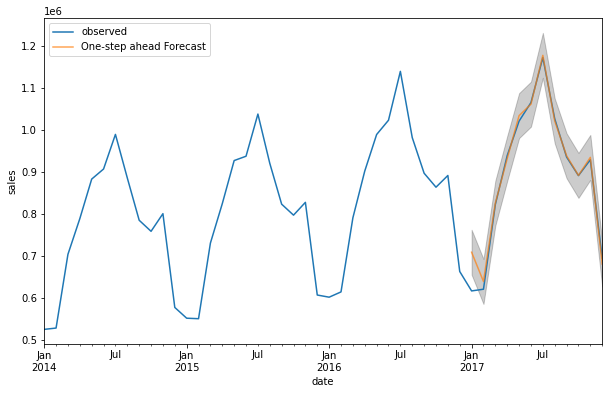

In [63]:
#绘制结果图
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7, figsize=(10, 6))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('sales')
plt.legend()

# 4.建一个for循环的ARIMA模型

In [28]:
##在这里，ARIMA模型的限制，我们在这里拟合的只是这家公司全部的销量数据
##但是对于一家拥有10家零售商店、50种产品的零售企业来说，
##只有详细到对于每一种产品在每家店铺的销售预测，才能指导这家公司进行库存管理。
#创建一个空列表，用于循环预测时，最后导入预测结果使用
subs_add = pd.DataFrame({'month':[],'sales_forecast':[],'item':[],'store':[]})

In [29]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))#对p,d,q的所有可能取值，进行配对组合
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [30]:
##定义得到最佳参数的函数
def param_func(y):   
    cnt = 0
    pdq_test =[]
    seasonal_pdq_test =[]
    AIC = []
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                results = mod.fit()
                cnt += 1
                if cnt % 50 :
                    pdq_test.append(param)
                    seasonal_pdq_test.append(param_seasonal)
                    AIC.append(results.aic)
                    #print('Current Iter - {}, ARIMA{}x{} 12 - AIC:{}'.format(cnt, param, param_seasonal, results.aic))
            except:
                continue
    v = AIC.index(min(AIC))
    pdq_opt = pdq_test[v]
    seasonal_pdq_opt = seasonal_pdq_test[v]
    param_opt = [pdq_opt,seasonal_pdq_opt]
    return param_opt

In [31]:
##定义得到预测结果，并添加至subs_add的函数
def forecast_func(y):
    param_opt = param_func(y)
    pdq_opt = param_opt[0]
    seasonal_pdq_opt = param_opt[1]
    #print('开始拟合模型第{}，{}次'.format(m,n))
    #使用最优参数进行模型拟合
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=pdq_opt,
                                seasonal_order=seasonal_pdq_opt,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()

    #这里的get_forecast是外推XX步预测，get_prediction是按照时间点要求，对数据进行预测
    pred_forecast = results.get_forecast(steps=12)
    forecast = pred_forecast.predicted_mean
    
    #type(forecast)
    #数据类型为pandas.core.series.Series，为了后续操作方便，我们将其转为pandas dataframe
    dict_f = {'month':forecast.index,'sales_forecast':forecast.values}#先将数据转变为字典
    df_forecast = pd.DataFrame(dict_f)#转换数据类型为dataframe
    
    #在dataframe中添加“item”和“store”列，赋值与循环到的m,n值一致
    df_forecast['item'] = m
    df_forecast['store'] = n
    
    #向最终结果列表中，按行添加最终预测结果
    global subs_add
    subs_add.append(df_forecast,ignore_index=True)
    
    #需要赋值给subs_add，不然数据是没有写入的
    subs_add = subs_add.append(df_forecast,ignore_index=True)
    return subs_add

In [32]:
#使用for循环，依次得到所有item(m)和store(n)组合下的销量预测。
    ###！！！提示：运行单次一般需要数分钟时间，运行50个商品X10店次
    ###意味着需要数百分钟（至少5个小时以上）
    ###如果是为了观察，建议把下面的 m in range(1,51) 改为（1,3)，n in range(1,11)改为(4,6)
    ###这样调整后的运行时间会缩短到10分钟左右。
import warnings
warnings.filterwarnings("ignore")
pair= []#
for m in range(1,3):
    for n in range(4,6): #封装多个变量的循环
        df = df_raw.query('item == {} & store == {}'.format(m,n))
        y = df['sales'].resample('MS').sum() 
        print('开始参数测算第{}，{}次'.format(m,n))
        df_forecast = forecast_func(y)
        pair.append([m,n])

print(pair)#检查是否所有配对的（m,n）都完成
subs_add.head()#检查列表结果的格式

开始参数测算第1，4次
开始参数测算第1，5次
开始参数测算第2，4次
开始参数测算第2，5次
[[1, 4], [1, 5], [2, 4], [2, 5]]


,month,sales_forecast,item,store
0,2018-01-01,759.270054,1.0,4.0
1,2018-02-01,687.360578,1.0,4.0
2,2018-03-01,978.443359,1.0,4.0
3,2018-04-01,1191.591241,1.0,4.0
4,2018-05-01,1236.892560,1.0,4.0


In [37]:
##保证店铺和产品编号为整数
subs_add['item'] = subs_add['item'].astype('int')
subs_add['store'] = subs_add['store'].astype('int')

print(subs_add)#打印所有商店各类产品的销售情况

        month  sales_forecast  item  store
0  2018-01-01      759.270054     1      4
1  2018-02-01      687.360578     1      4
2  2018-03-01      978.443359     1      4
3  2018-04-01     1191.591241     1      4
4  2018-05-01     1236.892560     1      4
5  2018-06-01     1529.784401     1      4
6  2018-07-01     1566.867122     1      4
7  2018-08-01     1631.631561     1      4
8  2018-09-01     1371.550268     1      4
9  2018-10-01     1680.460776     1      4
10 2018-11-01     1520.144933     1      4
11 2018-12-01     1557.848813     1      4
12 2018-01-01      377.612418     1      5
13 2018-02-01      484.326502     1      5
14 2018-03-01      575.288415     1      5
15 2018-04-01      624.079824     1      5
16 2018-05-01      683.131966     1      5
17 2018-06-01      714.517018     1      5
18 2018-07-01      782.065680     1      5
19 2018-08-01      699.206176     1      5
20 2018-09-01      661.776650     1      5
21 2018-10-01      709.621858     1      5
22 2018-11-

In [38]:
#将预测结果保存到本地cvs文件
subs_add.to_csv('Result.csv')

In [39]:
###最后，上面这种循环的方法，效率其实较低，所以大家往往会使用更有效率的机器算法来替代
###机器学习，本质上是学习特征（feature）和结果变量之间的关系
###但是我们所拥有的训练数据中，只有date,item,sales几个特征变量，并不够充分
###所以在处理前，我们往往会从日期中提取更多信息，比如这一天是一周的第几天、这一周是这年的第几周

In [44]:
#为了让日期成为一个变量列，我们可以使用reset_index()，重新进行索引
##DataFrame.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill=”) 
##level控制了具体要还原的那个等级的索引 
##drop为False则索引列会被还原为普通列，否则会丢失
df_fe=df_raw.reset_index(drop=False)
df_fe.head()

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


In [45]:
##提取日期特征
df_fe['dayofmoth']=df_fe.date.dt.day
df_fe['dayofyear']=df_fe.date.dt.dayofyear
df_fe['dayofweek']=df_fe.date.dt.dayofweek
df_fe['month']=df_fe.date.dt.month
df_fe['year']=df_fe.date.dt.year
df_fe['weekofyear']=df_fe.date.dt.weekofyear
df_fe['is_month_start']=(df_fe.date.dt.is_month_start).astype(int)
df_fe['is_month_end']=(df_fe.date.dt.is_month_end).astype(int)

In [46]:
df_fe.head()

,date,store,item,sales,dayofmoth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,1,1,1,1,2013,1,1,0
1,2013-01-02,1,1,11.0,2,2,2,1,2013,1,0,0
2,2013-01-03,1,1,14.0,3,3,3,1,2013,1,0,0
3,2013-01-04,1,1,13.0,4,4,4,1,2013,1,0,0
4,2013-01-05,1,1,10.0,5,5,5,1,2013,1,0,0


In [43]:
###这样可以在机器中，更好地体现销量时间序列的季节性、趋势性等特征
###这个过程，被我们称为Feature Engineering
###在完成上面这个FE过程后，我们再考虑使用XGBoost等流行的算法进行处理。